<a href="https://colab.research.google.com/github/Necrotox/Necrotox/blob/main/start_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q --no-warn-script-location --index-url https://download.pytorch.org/whl/cpu \
  torch==2.7.1+cpu > /dev/null 2>&1

!pip install -q --no-warn-script-location --index-url https://download.pytorch.org/whl/cpu \
  torchvision==0.22.0+cpu > /dev/null 2>&1
!pip install -q --no-warn-script-location --index-url https://download.pytorch.org/whl/cpu \
  torchaudio==2.7.1+cpu > /dev/null 2>&1

!pip install -q --no-warn-script-location \
  pytorch-lightning==2.5.2 pytorch-forecasting==1.4.0 > /dev/null 2>&1

!pip install -q tinkoff-investments dill telebot --upgrade mplfinance > /dev/null 2>&1

In [37]:
import asyncio
import contextlib
import functools
import statsmodels.api as sm
import inspect
import zipfile
import pickle
import json
import gc
import re
import io
import time
import typing
import logging
import pytz
import gzip
import dill
import lzma
import pandas as pd
import nest_asyncio
import hashlib
import random
import joblib
import math
import psutil

import scipy.sparse as sp
import scipy.sparse.linalg as spla


from numba import jit, njit
from grpc import StatusCode
from grpc.aio import AioRpcError
from dataclasses import dataclass
from contextlib import redirect_stderr, redirect_stdout
from collections.abc import Sequence
from tinkoff.invest import AsyncClient, CandleInterval
from tinkoff.invest.exceptions import RequestError
from tinkoff.invest import (
    AsyncClient,
    #CandleInstrument,
    MarketDataRequest,
    #SubscribeCandlesRequest,
    #SubscriptionAction,
    SubscriptionInterval,
)
from tinkoff.invest.schemas import (
    SubscribeCandlesRequest,
    SubscriptionAction,
    CandleInstrument,
)
from tinkoff.invest.market_data_stream.market_data_stream_manager import MarketDataRequest
from tinkoff.invest.schemas import Candle
from statsmodels.tsa.seasonal import STL
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from collections import defaultdict, deque
from multiprocessing import Process
from multiprocessing import Process
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
import mplfinance as mpf
import telebot
import datetime
import matplotlib
from sklearn.neighbors import NearestNeighbors
from scipy.signal import lfilter

from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.stats import norm, pearsonr
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import BaseCrossValidator

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import BallTree

from bisect import bisect_left

from pandas.tseries.frequencies import to_offset
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import EncoderNormalizer
from pytorch_forecasting.metrics import Metric, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import RichProgressBar, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import MeanSquaredError
from torchmetrics.functional import mean_squared_error as torchmetrics_mse

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Any, Dict, Iterable, Iterator, List, Literal, Mapping, Optional, Tuple
import os, gc, warnings, typing as tp

from lightgbm import LGBMRegressor
import lightgbm as lgb

matplotlib.use("agg")
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings('ignore')

import psutil
import os.path

nest_asyncio.apply()

# Настройка логирования
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

TOKEN = 't.bWjxPlU6vz77qoqS754OKy0QorLDaZP-CE091dhGl56v7GHrqgF-mQAdWaeRg2kDRJmmxzvaaOwKUTxW6dnOKg'

TICKERS1 =  ['RAGR', 'MGNT', 'MSTT', 'VRSB', 'PRFN', 'MTLR', 'LIFE', 'UPRO', 'GECO',
       'BANE', 'MTLRP', 'GEMC', 'NVTK', 'TRNFP', 'TRMK', 'LSNGP', 'OBNEP',
       'SNGSP', 'UWGN', 'MRKP', 'KZOSP', 'YDEX', 'NLMK', 'IRKT', 'CNTLP',
       'LENT', 'KLSB', 'SELG', 'NMTP', 'UNAC', 'VKCO', 'MRKU', 'UGLD', 'NTZL',
       'BANEP', 'FLOT', 'TGKJ', 'MAGN', 'ROSN', 'TGKB', 'AFKS', 'TTLK', 'HEAD',
       'KZIZ', 'NOMP', 'OKEY', 'ABRD', 'NSVZ', 'MRKV', 'LSNG', 'MRKC', 'SVAV',
       'ETLN', 'MRKZ', 'LNZL', 'CNRU', 'BSPB', 'RBCM', 'PMSB', 'LSRG', 'RNFT',
       'MOEX', 'GTRK', 'NKHP', 'LKOH', 'SBERP', 'SBER', 'PLZL', 'RENI', 'MDMG',
       'AFLT', 'FESH', 'OBNE', 'X5', 'MGTSP', 'DVEC', 'KROT', 'TATNP', 'OZPH',
       'TGKN', 'TATN', 'PMSBP', 'TGKBP', 'SPBE', 'LNZLP', 'CHMK', 'KZIZP',
       'RKKE', 'FRHC']

TICKERS = ['MRKV']#, 'NOMP', 'OBNEP']


DATA_PATH = '/content/drive/MyDrive/t_ml/data/'
path_to_save = '/content/drive/MyDrive/t_ml/data/'
CANDLE_INTERVAL = CandleInterval.CANDLE_INTERVAL_15_MIN
TIMEFRAME_MINUTES = 15
HISTORY_DATA_POINTS = 5000


try:
    with open(f'{path_to_save}open_price.txt', 'r') as f:
        open_price = json.loads(f.read())

    with open(f'{path_to_save}close_price.txt', 'r') as f:
        close_price = json.loads(f.read())

    with open(f'{path_to_save}high_price.txt', 'r') as f:
        high_price = json.loads(f.read())

    with open(f'{path_to_save}low_price.txt', 'r') as f:
        low_price = json.loads(f.read())

    with open(f'{path_to_save}volume.txt', 'r') as f:
        volume = json.loads(f.read())

    print("Данные 1 успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    open_price, close_price, high_price, low_price, volume = {}, {}, {}, {}, {}
    await asyncio.sleep(60)

try:
    with open(f'{path_to_save}time_last_kline_start.txt', 'r') as f:
        time_last_kline_start = json.loads(f.read())

    with open(f'{path_to_save}time_last_kline_end.txt', 'r') as f:
        time_last_kline_end = json.loads(f.read())

    with open(f'{path_to_save}ma.txt', 'r') as f:
        ma = json.loads(f.read())

    with open(f'{path_to_save}open_trades.txt', 'r') as f:
        open_trades = json.loads(f.read())

    with open(f'{path_to_save}trading_data.txt', 'r') as f:
        trading_data = json.loads(f.read())

    print("Данные 2 успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    time_last_kline_start, time_last_kline_end, ma, open_trades, trading_data = {}, {}, {}, {}, {}
    await asyncio.sleep(60)

try:

    with open(f'{path_to_save}pmax.txt', 'r') as f:
        pmax = json.loads(f.read())

    with open(f'{path_to_save}signals.txt', 'r') as f:
        signals = json.loads(f.read())

    print("Данные 3 успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    pmax, signals = {}, {}
    await asyncio.sleep(60)

print('Загрузка Моделей', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")

try:
    kmeans_global = joblib.load(f'{path_to_save}models/kmeans_global.pkl')
    print('Модель MiniBatchKMeans успешно загруженна', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")

except Exception as e:
    print(f"Ошибка при загрузке модели MiniBatchKMeans: {e}")
    kmeans_global = joblib.load(f'{path_to_save}models/kmeans_global.pkl')
    print('Модель MiniBatchKMeans загруженна со второй попытки', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)

try:
    scaler_global = joblib.load(f'{path_to_save}models/scaler_global.pkl')
    print('Скалер успешно загружен', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")

except Exception as e:
    print(f"Ошибка при загрузке модели MiniBatchKMeans: {e}")
    scaler_global = joblib.load(f'{path_to_save}models/scaler_global.pkl')
    print('Скалер загружен со второй попытки', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)
'''
try:
    with open(f'{path_to_save}/models/regression_model_general.dill', 'rb') as file:
        regression_model = dill.load(file)
        print('Модель выхода из сделки загруженна', f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
except Exception as e:
    print(f"Ошибка при загрузке модели регрессии: {e}")
    with open(f'{path_to_save}/models/regression_model_general.dill', 'rb') as file:
        regression_model = dill.load(file)
        print('Модель выхода из сделки загруженна с второйпопытки',
              f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)
try:
    with open(f'{path_to_save}/models/global_model.dill', 'rb') as file:
        classifier_model = dill.load(file)
        print('Глобальная модель поиска входа для всех кластеров заргуженна',
              f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
except Exception as e:
    print(f"Ошибка при загрузке модели поиска входа для 0 кластера: {e}")
    with open(f'{path_to_save}/ful_tickers_params.txt', 'rb') as file:
        classifier_model = dill.load(file)
        print('Глобальная модель поиска входа для всех кластеров загруженна с второй попытки',
              f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)
'''

try:
    with open(f'{path_to_save}/ful_tickers_params_new.txt', 'r') as file:
      ticker_params = json.load(file)
      print('Параметры для тикетов загруженны',
            f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
except Exception as e:
    print(f"Ошибка при загрузке параметров тикетов: {e}")
    with open(f'{path_to_save}/ful_tickers_params_new.txt', 'r') as file:
        ticker_params = json.load(file)
        print('Параметры для тикетов загруженны со второй попытки',
              f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)

try:
    #transformers_path = f'{path_to_save}/models/neuros/'
    #models_path = f'{path_to_save}/models/final_models/'

    with open(f'{path_to_save}/models/final_cols.pkl', 'rb') as f:
        final_cols = pickle.load(f)

    with open(f'{path_to_save}/models/final_params.pkl', 'rb') as f:
        final_params = pickle.load(f)

    with open(f'{path_to_save}/models/best_methods.json', 'rb') as f:
        methods = json.load(f)

    with open(f'{path_to_save}close_preds.txt', 'r') as f:
        close_preds = json.loads(f.read())

except Exception as e:
    print(f"Ошибка при определении пути на модели и трансформеры: {e}")
    await asyncio.sleep(60)

try:
    with open(f'{path_to_save}/phase_ful_tickers_params.txt', 'r') as file:
      phase_ticker_params = json.load(file)
      print('Параметры для тикетов с фазами загруженны',
            f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
except Exception as e:
    print(f"Ошибка при загрузке параметров тикетов с фазами: {e}")
    with open(f'{path_to_save}/phase_ful_tickers_params.txt', 'r') as file:
        phase_ticker_params = json.load(file)
        print('Параметры для тикетов с фазами загруженны со второй попытки',
              f"Память: {psutil.Process().memory_info().rss / 1024 ** 2:.2f} МБ")
    await asyncio.sleep(60)


def _whittaker_smooth(y: np.ndarray, lam: float = 50.0) -> np.ndarray:
    """
    Whittaker–Eilers smoothing (penalized least squares, D2).
    Линейный безфазовый фильтр, хорошо убирает шум, не смещая тренд.
    """
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla

    n = len(y)
    if n <= 2:
        return y.copy()

    E = sp.eye(n, format="csc")
    # Вторая разность (D2): размер (n-2) x n
    diagonals = [np.ones(n), -2*np.ones(n), np.ones(n)]
    D2 = sp.diags(diagonals, [0, 1, 2], shape=(n-2, n), format="csc")
    coef = E + lam * (D2.T @ D2)
    z = spla.spsolve(coef, y.astype(float))
    return z

def _rearrange_preserving_marginal(z_raw: np.ndarray, z_smooth: np.ndarray) -> np.ndarray:
    """
    Distribution-preserving smoothing via monotone rearrangement:
    - сортируем исходный z_raw -> z_sorted,
    - берём порядок (argsort) сглаженного z_smooth,
    - раскладываем z_sorted по этому порядку.
    В итоге: гладко по времени (за счёт порядка z_smooth), но эмпирическое
    распределение строго совпадает с исходным (z_raw).
    """
    if len(z_raw) == 0:
        return z_raw
    order = np.argsort(z_smooth)
    z_sorted = np.sort(z_raw)
    out = np.empty_like(z_raw)
    out[order] = z_sorted
    return out

def calculate_smoothed_target_qnorm(
    df: pd.DataFrame,
    *,
    batch_start: int = 0,
    epsilon: float = 1e-6,
    round_decimals: int = 1,

    # базовая нормализация по окну (buy->sell)
    tight_spread_thr: float = 1e-4,

    # сглаживание в z-домене
    smooth_method: Literal["gauss", "savgol", "whittaker"] = "gauss",
    gauss_sigma: float = 2.0,
    savgol_window: int = 11,   # нечётное
    savgol_poly: int = 3,
    whittaker_lambda: float = 50.0,

    # квантильная нормализация и глобальный маппинг
    clip_z: float = 2.5,       # клип в z-подобной шкале перед [-1,1]
    tanh_scale: float | None = None,

    # джиттер перед ECDF
    dequant_jitter: float = 1e-4,

    # опция "обязательно растянуть каждый батч" (робастная эквализация по квантилям)
    per_batch_equalize: bool = False,
    per_batch_q: float = 0.01,  # напр. 1% и 99% -> [-1, 1]

    random_state: int | None = 42,
) -> pd.DataFrame:
    """
    Возвращает df с колонками:
      - normalized_target ∈ [-1, 1] (единая глобальная шкала)
      - batch (int64): идентификатор события (buy→sell)

    Алгоритм:
      1) Внутри каждого события: base(0..1) -> ECDF -> z_raw ~ N(0,1).
      2) Сглаживаем (Gaussian/Savitzky–Golay/Whittaker) -> z_smooth.
      3) Rearrangement: z_preserved = rearrange(z_raw, order-of z_smooth).
         Это убирает шум, но полностью сохраняет исходное распределение.
      4) Глобальная квантильная нормализация: приводим все батчи к общей
         маргинальной функции Q_global(p).
      5) Единая глобальная шкала (median/MAD), клип до [-clip_z, clip_z],
         линейный маппинг в [-1, 1], опционально tanh.
      6) (Опционально) per-batch эквализация по квантилям до [-1, 1].
    """
    rng = np.random.default_rng(random_state)
    df = df.copy()
    df["normalized_target"] = np.nan
    df["batch"] = np.nan
    df["event_sell_time"] = pd.to_datetime(df["event_sell_time"], utc=True)

    if savgol_window % 2 == 0:
        savgol_window += 1
    use_savgol = (savgol_window >= savgol_poly + 2)

    all_indices: list[np.ndarray] = []
    all_z_preserved: list[np.ndarray] = []
    batch = batch_start

    buy_rows = df.index[df["buy_signal"] == True]
    for start_i in buy_rows:
        sell_time = df.at[start_i, "event_sell_time"]
        if pd.isna(sell_time):
            continue
        sell_rows = df.index[df["time"] == sell_time]
        if len(sell_rows) == 0:
            continue
        end_i = sell_rows[0]

        mask = (df.index >= start_i) & (df.index <= end_i)
        idx = df.index[mask]
        if idx.empty:
            continue

        high_s = df.loc[idx, "high"]
        low_s  = df.loc[idx, "low"]

        # Робастные полки только для базовой формы (0..1)
        max_p = np.round(high_s.quantile(0.92), round_decimals)
        min_p = np.round(low_s .quantile(0.08), round_decimals)
        if max_p - min_p < tight_spread_thr:
            max_p, min_p = float(high_s.max()), float(low_s.min())

        use_profit_norm = (max_p - min_p) < tight_spread_thr

        # 1) base 0..1
        if not use_profit_norm:
            base = (df.loc[idx, "close"] - min_p) / (max_p - min_p + 1e-12)
        else:
            buy_price = df.at[start_i, "close"]
            max_prof = (high_s.max() - buy_price) / max(buy_price, 1e-12)
            max_prof = max(max_prof, epsilon)
            base = (df.loc[idx, "close"] - buy_price) / (buy_price * max_prof)
            base = 0.5 + 0.5 * base

        base = np.clip(base.to_numpy(float), epsilon, 1 - epsilon)

        # Разбиваем дубликаты
        if dequant_jitter and len(base) > 0:
            base = base + rng.normal(scale=dequant_jitter, size=base.shape)
            base = np.clip(base, epsilon, 1 - epsilon)

        # 2) ECDF -> z_raw ~ N(0,1)
        n = len(base)
        ranks = pd.Series(base, index=idx).rank(method="first").to_numpy()
        ecdf = (ranks - 0.5) / max(n, 1)
        ecdf = np.clip(ecdf, epsilon, 1 - epsilon)
        z_raw = norm.ppf(ecdf)

        # 3) Сглаживание (без фазовых сдвигов)
        if n > 2:
            if smooth_method == "gauss":
                z_sm = gaussian_filter1d(z_raw, sigma=gauss_sigma, mode="nearest")
            elif smooth_method == "savgol" and use_savgol and n >= savgol_window:
                z_sm = savgol_filter(z_raw, window_length=savgol_window, polyorder=savgol_poly, mode="interp")
            elif smooth_method == "whittaker":
                z_sm = _whittaker_smooth(z_raw, lam=whittaker_lambda)
            else:
                # запасной вариант, если окно слишком короткое
                z_sm = z_raw.copy()
        else:
            z_sm = z_raw.copy()

        # 4) Rearrangement: сохраняем распределение z_raw, но используем порядок z_sm
        z_preserved = _rearrange_preserving_marginal(z_raw, z_sm)
        #z_preserved = np.where(z_preserved > 0, z_preserved * 1.2, z_preserved)  # Усиливаем положительные пики
        #z_preserved = np.clip(z_preserved, -clip_z * 1.5, clip_z * 1.5)

        all_indices.append(idx.to_numpy())
        all_z_preserved.append(z_preserved)
        df.loc[idx, "batch"] = batch
        batch += 1

    # Если событий не нашлось
    if len(all_indices) == 0:
        df["batch"] = df["batch"].fillna(batch_start).astype("int64", errors="ignore")
        df["normalized_target"] = df["normalized_target"].fillna(0.0)
        return df

    # 5) Глобальная квантильная нормализация: одна общая маргинальная функция
    z_pool = np.concatenate(all_z_preserved, axis=0)
    z_pool_sorted = np.sort(z_pool)
    N = len(z_pool_sorted)
    # сетка перцентилей соответствующая отсортированным значениям
    p_pool = (np.arange(N) + 0.5) / N

    def q_global(p: np.ndarray) -> np.ndarray:
        p = np.clip(p, p_pool[0], p_pool[-1])
        return np.interp(p, p_pool, z_pool_sorted)

    all_z_qn: list[np.ndarray] = []
    for z_preserved in all_z_preserved:
        n = len(z_preserved)
        # перцентиль внутри батча
        p_batch = (pd.Series(z_preserved).rank(method="first").to_numpy() - 0.5) / max(n, 1)
        z_qn = q_global(p_batch)  # теперь у батча та же маргиналка, что и у пула
        all_z_qn.append(z_qn)

    # 6) Единая глобальная шкала -> [-1, 1]
    g_med = np.median(z_pool)
    g_mad = np.median(np.abs(z_pool - g_med)) + 1e-12
    scale = 1.4826 * g_mad

    pos = 0
    for idx, z_qn in zip(all_indices, all_z_qn):
        z_g = (z_qn - g_med) / scale
        y = np.clip(z_g, -clip_z, clip_z) / clip_z
        if tanh_scale:
            y = np.tanh(y * tanh_scale) / np.tanh(tanh_scale)

        # 7) (опционально) робастная per-batch эквализация до [-1,1]
        if per_batch_equalize and len(y) >= 3:
            q = per_batch_q
            lo, hi = np.quantile(y, [q, 1 - q])
            if hi - lo > 1e-12:
                y = (y - lo) / (hi - lo)  # [0..1]
                y = 2.0 * np.clip(y, 0.0, 1.0) - 1.0  # [-1..1]
            y = np.clip(y, -1.0, 1.0)

        df.loc[idx, "normalized_target"] = y
        pos += len(idx)

    df["batch"] = df["batch"].astype("int64", errors="ignore")
    return df

time_last_kline_dt_cache = {}

def _to_utc_floor_minute(ts):
    return pd.to_datetime(ts, utc=True).floor('T')

def _iso_utc(ts):
    return pd.Timestamp(ts, tz='UTC').floor('T').isoformat()

def _get_dt_scale_for_ticker(ticker):
    times_iso = time_last_kline_start.get(ticker, [])
    if not times_iso:
        return pd.DatetimeIndex([])
    if ticker not in time_last_kline_dt_cache or len(time_last_kline_dt_cache[ticker]) != len(times_iso) or (
        len(times_iso) and time_last_kline_dt_cache[ticker][-1] != _to_utc_floor_minute(times_iso[-1])
    ):
        time_last_kline_dt_cache[ticker] = pd.DatetimeIndex(pd.to_datetime(times_iso, utc=True))
    return time_last_kline_dt_cache[ticker]


def _slice_indices_by_time(ticker, start_time_utc=None, end_time_utc=None):
    """
    Возвращает (start_idx, end_idx) по шкале time_last_kline_start[ticker], границы включительные.
    Если start_time_utc/end_time_utc None — граница опущена.
    Возвращает None, если шкала пуста или нет пересечения.
    """
    dt_scale = _get_dt_scale_for_ticker(ticker)
    if len(dt_scale) == 0:
        return None

    if start_time_utc is None:
        start_idx = 0
    else:
        start_ts = _to_utc_floor_minute(start_time_utc)
        start_idx = int(dt_scale.searchsorted(start_ts, side='left'))
        if start_idx >= len(dt_scale):
            return None

    if end_time_utc is None:
        end_idx = len(dt_scale) - 1
    else:
        end_ts = _to_utc_floor_minute(end_time_utc)
        # хотим включительно — берем правую границу и вычитаем 1, но если точное совпадение c началом свечи — ок
        end_idx = int(dt_scale.searchsorted(end_ts, side='right') - 1)
        if end_idx < 0:
            return None

    if start_idx > end_idx:
        return None
    return start_idx, end_idx

def _now_monotonic():
    return time.monotonic()

def _exponential_backoff(attempt: int, base=1.0, cap=15.0, jitter=True):
    # attempt: 0,1,2,...
    delay = min(cap, base * (2 ** attempt))
    if jitter:
        # Полуджиттер: равномерный [delay/2, delay]
        return random.uniform(delay / 2, delay)
    return delay

def _is_retryable_grpc_error(e: AioRpcError) -> bool:
    code = e.code()
    # UNAVAILABLE и CANCELLED — точно перезапускаем
    if code in (StatusCode.UNAVAILABLE, StatusCode.CANCELLED, StatusCode.DEADLINE_EXCEEDED):
        return True
    # INTERNAL иногда тоже имеет смысл ретраить, но осторожно
    if code == StatusCode.INTERNAL:
        return True
    return False

def _is_retryable_generic_error(err: Exception) -> bool:
    s = str(err)
    needles = [
        "Remote end closed connection without response",
        "RST_STREAM",
        "Connection reset by peer",
        "Server disconnected",
        "Transport closed",
        "EOF occurred in violation of protocol",
        "Stream removed",
        "recvmsg",
        "Broken pipe",
        "Timed out",
    ]
    return any(n in s for n in needles)

@dataclass
class TransformerEntry:
    pipe: Pipeline  # preprocessing -> to_dense -> model

@dataclass
class LGBEntry:
    best_method: str
    pipe_reg: Optional[Pipeline]
    pipe_rank: Optional[Pipeline]
    meta: Dict[str, Any]
    threshold: float
    calib_reg: Dict[str, float]
    w_reg: Optional[float]

class ModelsRuntimeCache:
    def __init__(self):
        self.transformers_path: str = ""
        self.models_path: str = ""
        self.final_cols: Dict[str, list] = {}
        self.final_params: Dict[str, Any] = {}
        self.methods: Dict[str, str] = {}
        self.scaler_global = None
        self.kmeans_global = None
        self.transformers: Dict[str, TransformerEntry] = {}
        self.lgb_models: Dict[str, LGBEntry] = {}

    def init_metadata(self, path_to_save: str):
        # Нормализуем пути
        self.transformers_path = os.path.join(path_to_save, "models", "neuros")
        self.models_path = os.path.join(path_to_save, "models", "final_models")

        # Метаданные
        with open(os.path.join(path_to_save, "models", "final_cols.pkl"), "rb") as f:
            self.final_cols = pickle.load(f)
        with open(os.path.join(path_to_save, "models", "final_params.pkl"), "rb") as f:
            self.final_params = pickle.load(f)
        with open(os.path.join(path_to_save, "models", "best_methods.json"), "rb") as f:
            self.methods = json.load(f)

        # Глобальные объекты
        self.scaler_global = joblib.load(os.path.join(path_to_save, "models", "scaler_global.pkl"))
        self.kmeans_global = joblib.load(os.path.join(path_to_save, "models", "kmeans_global.pkl"))

    def _has_transformer_on_disk(self, ticker: str) -> bool:
        base = os.path.join(self.transformers_path, ticker)
        return os.path.isdir(base)

    def _has_lgb_on_disk(self, ticker: str) -> bool:
        # Если у вас load_model_for_ticker сам умеет искать файлы — можно опустить эту проверку.
        # Оставим мягкую проверку по каталогу тикера.
        base = os.path.join(self.models_path, ticker)
        return os.path.isdir(base)

    def load_transformer_for(self, ticker: str, device: Optional[str] = "cpu") -> Optional[Pipeline]:
        if ticker in self.transformers:
            return self.transformers[ticker].pipe
        if not self._has_transformer_on_disk(ticker):
            return None
        base = os.path.join(self.transformers_path, ticker)
        pipe = load_transformer_exact(base, device=device or "cpu")
        self.transformers[ticker] = TransformerEntry(pipe=pipe)
        return pipe

    def load_lgb_for(self, ticker: str) -> Optional[LGBEntry]:
        if ticker in self.lgb_models:
            return self.lgb_models[ticker]
        if not self._has_lgb_on_disk(ticker):
            return None
        data = load_model_for_ticker(ticker, models_dir=self.models_path)
        entry = LGBEntry(
            best_method=data["best_method"],
            pipe_reg=data.get("pipe_reg"),
            pipe_rank=data.get("pipe_rank"),
            meta=data.get("meta", {}),
            threshold=data.get("threshold", 0.0),
            calib_reg=data.get("calib_reg", {"a": 1.0, "b": 0.0}),
            w_reg=data.get("w_reg"),
        )
        self.lgb_models[ticker] = entry
        return entry

    def preload_all(self, tickers: list, device: str = "cpu"):
        """Аккуратно предзагружает модели только для тех тикеров, которые есть во всех справочниках
        и у которых реально есть файлы на диске. Остальные — тихо пропускает."""
        loaded, skipped = [], []

        for t in tickers:
            # Проверим наличие описаний в метаданных
            has_params = t in self.final_params
            has_cols = t in self.final_cols
            # Выбираем метод, но отсутствие метода не критично — дефолт 'regressor'
            method = self.methods.get(t, "regressor")

            if not (has_params and has_cols):
                skipped.append((t, "no_meta"))
                continue

            # Трансформер
            tr_ok = self.load_transformer_for(t, device=device) is not None
            # LGB
            lgb_ok = self.load_lgb_for(t) is not None

            if tr_ok and lgb_ok:
                loaded.append(t)
            else:
                reason = ("no_transformer" if not tr_ok else "no_lgb")
                skipped.append((t, reason))

        return {"loaded": loaded, "skipped": skipped}

def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X

class ToDenseTransformer(BaseEstimator, TransformerMixin):
    """Преобразует разреженную матрицу в плотную numpy-массив."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if issparse(X):
            return X.toarray()
        return X
    def get_feature_names_out(self, input_features: tp.Sequence[str] | None = None):
        return np.asarray(input_features) if input_features is not None else np.array([])

def deep_elbow(imp: np.ndarray, win: int = 5, eps: float = 0.02) -> int:
    """
    Берём окно длиной win, считаем средний относительный спад.
    Первое место, где спад < eps, считаем плато.
    """
    if len(imp) <= win:
        return len(imp)
    dif = np.abs(np.diff(imp) / (imp[:-1] + 1e-9))
    # скользящее среднее
    m = np.convolve(dif, np.ones(win) / win, mode="valid")
    flat = np.nonzero(m < eps)[0]
    return int(flat[0] + win) if flat.size else len(imp)

# ───────────────────────────────────────────────────────
# 2.  корреляционная чистка (быстрая, исправленная)
# ───────────────────────────────────────────────────────
def corr_prune(df: pd.DataFrame, feats: list[str], thr=.95) -> list[str]:
    if len(feats) < 2 or thr >= 1:
        return feats
    X  = df[feats].apply(pd.to_numeric, errors='ignore')
    C  = X.corr().abs().to_numpy()
    keep = []
    for i in range(len(feats)):
        if not keep or C[i, keep].max() < thr:
            keep.append(i)
    return [feats[i] for i in keep]

# ───────────────────────────────────────────────────────
# 3.  универсальный быстрый селектор
# ───────────────────────────────────────────────────────
def fast_feature_select(
        res           : pd.DataFrame,      # feature / importance
        df_full       : pd.DataFrame,      # датасет для corr-prune
        target_col    : str = "target",
        *,
        method        : str = "elbow",     # elbow | deep_elbow | percentile | quantile | top_k
        top_k         : int = 150,         # для method="top_k"
        perc_limit    : float = .90,       # для method="percentile"
        quantile_q    : float = .10,       # для method="quantile"
        elbow_eps     : float = .05,       # (> flat %) для (shallow) elbow
        deep_win      : int = 5,           # окно для deep_elbow
        deep_eps      : float = .02,       # порог для deep_elbow
        corr_thr      : float = .95        # корреляционный порог
) -> list[str]:

    ranked = res.sort_values("importance", ascending=False).reset_index(drop=True)
    feats  = ranked.feature.to_numpy()
    imps   = ranked.importance.to_numpy()

    # ---------- 1) сколько оставить  ----------
    if method == "elbow":                 # одношаговое колено
        k = np.argmax(np.abs(np.diff(imps) / (imps[:-1] + 1e-9)) < elbow_eps) + 1
        if k == 1:        # колено не найдено
            k = len(imps)
    elif method == "deep_elbow":
        k = deep_elbow(imps, win=deep_win, eps=deep_eps)
    elif method == "percentile":          # кумулятивная доля
        cum = np.cumsum(imps)
        k   = np.searchsorted(cum / cum[-1], perc_limit) + 1
    elif method == "quantile":
        thr = np.quantile(imps, 1 - quantile_q)
        k   = int((imps >= thr).sum())
    elif method == "top_k":
        k = min(top_k, len(feats))
    else:
        raise ValueError("unknown method")

    selected = feats[:k].tolist()

    # ---------- 2) корреляционная чистка ----------
    selected = corr_prune(
        df_full.drop(columns=[target_col], errors='ignore'),
        selected,
        thr=corr_thr
    )

    return selected

def patch_feature_timings(cls):
    """
    Оборачивает все методы cls, начинающиеся на _feat_,
    и складывает затраченное время в self._timings[method_name].
    Вызывать сразу после объявления класса.
    """
    def timed(func):
        def wrapper(self, *args, **kwargs):
            t0 = time.perf_counter()
            result = func(self, *args, **kwargs)
            dt = time.perf_counter() - t0
            # заводим словарь при первом же вызове
            if not hasattr(self, "_timings"):
                self._timings = {}
            self._timings[func.__name__] = dt
            return result
        return wrapper

    for name, method in inspect.getmembers(cls, inspect.isfunction):
        if name.startswith("_feat_"):             # ← только расчётные функции
            setattr(cls, name, timed(method))

    return cls

def _slope(y):
        x = np.arange(len(y))
        # линейная регрессия «по формуле»
        xm, ym = x.mean(), y.mean()
        beta = ((x - xm) * (y - ym)).sum() / ((x - xm)**2).sum()
        return beta

@njit
def _rolling_entropy_exact_numba(x, window):
    """ Точная реализация rolling entropy с bins='auto' для каждого окна. """
    n = len(x)
    res = np.empty(n, dtype=np.float32)
    res[:] = np.nan
    if window < 2:
        return res
    for end in range(window - 1, n):
        win = x[end - window + 1 : end + 1]
        a_min = np.min(win)
        a_max = np.max(win)
        if a_min == a_max:
            res[end] = 0.0
            continue
        sorted_win = np.sort(win)
        idx25 = int(0.25 * window)
        idx75 = int(0.75 * window)
        q25 = sorted_win[idx25]
        q75 = sorted_win[idx75]
        iqr = q75 - q25
        sturges = int(np.ceil(np.log2(window) + 1))
        if iqr > 0:
            bin_width = 2.0 * iqr / (window ** (1.0 / 3.0))
            fd = int(np.ceil((a_max - a_min) / bin_width))
        else:
            fd = 1
        nbins = max(sturges, fd, 1)
        edges = np.empty(nbins + 1, dtype=np.float32)
        step = (a_max - a_min) / nbins
        edges[0] = a_min
        for i in range(1, nbins):
            edges[i] = a_min + i * step
        edges[nbins] = a_max
        counts = np.zeros(nbins, dtype=np.int32)  # int32 достаточно для window<=1e9
        for val in win:
            idx = np.searchsorted(edges, val, side='right') - 1
            if 0 <= idx < nbins:
                counts[idx] += 1
        ent = 0.0
        total = float(window)
        for c in counts:
            if c > 0:
                p = c / total
                ent -= p * np.log(p + 1e-10)
        res[end] = ent
    return res

@jit(nopython=True)
def rolling_autocorr(arr, window):
    n = len(arr)
    result = np.full(n, 0.0)
    for i in range(n):
        start = max(0, i - window + 1)
        w = i - start + 1
        if w <= 1:
            continue
        s = arr[start: i + 1]
        a = s[1:]
        b = s[:-1]
        n_pts = w - 1
        mean_a = np.sum(a) / n_pts
        mean_b = np.sum(b) / n_pts
        cov = np.dot(a, b) / n_pts - mean_a * mean_b
        var_a = np.dot(a, a) / n_pts - mean_a * mean_a
        var_b = np.dot(b, b) / n_pts - mean_b * mean_b
        if var_a <= 0 or var_b <= 0:
            result[i] = np.nan
        else:
            std_a = np.sqrt(var_a)
            std_b = np.sqrt(var_b)
            result[i] = cov / (std_a * std_b)
    return result


# ------------------------------------------------------------------------------
@patch_feature_timings
class FeatureCalculatorForRegression:
    """
    df  -- исходный OHLCV-DataFrame.
    required_features -- список имён колонок, которые нужны модели.
    params -- { primitive_name: {... гиперпараметры ...}, 'stat_window': int }.
    """

    _PRIMITIVES = {
        "MEDPRICE":               "_feat_base",
        "MACD":                   "_feat_macd",
        "MACD_Hist":              "_feat_macd",
        "Overbought_Oversold":    "_feat_overbought",
        "Overbought_Oversold_Index_mean": "_feat_overbought",
        "Price_MADist%":          "_feat_madist",
        "Mean_Reversion":         "_feat_mean_reversion",
        "Fear_Greed":             "_feat_fear_greed",
        "perc_var_open_close":    "_feat_price_variation",
        "pmax_norm":              "_feat_pmax_ma",
        "ma_norm":                "_feat_pmax_ma",
        "ma_pmax_norm_rage":      "_feat_pmax_ma",
        "ma_pmax_norm_rage_pct":  "_feat_pmax_ma",
        "slope_trend":            "_feat_slope",
        "ema_trend":              "_feat_ema_trend",
        "hp_trend":               "_feat_hp_trend",
        "trade_bars_counter":     "_feat_trade_duration",
        "ROC":                    "_feat_roc",
        "ATR_norm":               "_feat_atr",
        "BB_Width":               "_feat_bb_width",
        "Asset_Growth":           "_feat_asset_growth",
        "ema_acceleration":       "_feat_ema_acceleration",
        "price_change":           "_feat_price_change",
        "Asset_To_Equity_Ratio":  "_feat_asset_to_equity_ratio",
        "volume_ratio":           "_feat_fear_greed_index",
        "WILLR":                  "_feat_willr",
        "kf_trend":               "_feat_kf_trend",
        "Fractal_Dim":            "_feat_fractal_dim",
        "Peak_Exhaustion_Score":  "_feat_peak_exhaustion",
        "%B_BB":                  "_feat_bb_percent",
        "Kurtosis_roll":          "_feat_kurtosis_roll",
        "OBV_div":                "_feat_obv_div",
        "RSI_slope":              "_feat_rsi_slope",
        "Vol_Decay":              "_feat_vol_decay",
        "Accel_Decay":            "_feat_accel_decay",
        "Entropy_roll":           "_feat_entropy_roll",
        "Wavelet_Var_Ratio":      "_feat_wavelet_var",
        "Autocorr_Lag1":          "_feat_autocorr",
        "Beta_Market":            "_feat_beta",
        "PSC":                    "_feat_peak_squeeze_curvature",
        "PSC_raw":                "_feat_peak_squeeze_curvature",
        "PSC_z":                  "_feat_peak_squeeze_curvature",
        "PSC_sigmoid":            "_feat_peak_squeeze_curvature",
    }

    # СТАРАЯ: r"^ago_(\d+)_"
    # НОВАЯ: умеет и "ago50_", и "ago_50_"
    _LAG_RE  = re.compile(r"^ago_?(\d+)_")
    _STAT_RE = re.compile(r"_(mean|min|max|std|skew|kurt|quantile(\d{2}))$")
    _LOGSF   = "_logsf"

    def __init__(self, df: pd.DataFrame, ticker):
        self.df = df.copy()
        self.ticker = ticker
        f64 = self.df.select_dtypes("float64").columns
        self.df[f64] = self.df[f64].astype(np.float32)
        if "time" in self.df:
            ts = pd.to_datetime(self.df["time"], utc=True, errors="coerce")
            self.df["hour"]        = ts.dt.hour.astype("int8")
            self.df["day_of_week"] = ts.dt.day_of_week.astype("int8")

    def calculate_features(
        self,
        required_features: Iterable[str],
        params: Mapping[str, Mapping[str, Any]] | None = None
    ) -> pd.DataFrame:
        saved_cols = ['regime', 'normalized_target', 'batch', 'time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal',
                      'sell_signal', 'event_sell_time', 'event_sell_price', 'event_time', 'event_price', 'event_sell_time',
                      'event_sell_price', 'target', 'pnl', 'ma', 'pmax']
        self._params      = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        for col in required_features:
            self._ensure_column(col)
        out = self.df[list(required_features)].copy()
        f64 = out.select_dtypes("float64").columns
        out[f64] = out[f64].astype(np.float32)

        for mandatory_col in saved_cols:
            if mandatory_col in self.df.columns:
                out[mandatory_col] = self.df[mandatory_col]

        return out

    def calculate_all_possible_features(self, params: Mapping[str, Mapping[str, Any]] | None = None) -> pd.DataFrame:
        """
        Вычисляет все возможные фичи, исключая lag-версии для указанных колонок.
        Все бесконечные значения (np.inf/-np.inf) заменяются на 0.
        Порядок вычислений:
        1. Все базовые примитивы
        2. Lag-версии фич (кроме исключенных)
        3. Статистики для всех фич
        """
        # Инициализация параметров
        if not hasattr(self, '_params'):
            self._params = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)

        # Колонки, для которых не нужно создавать lag-версии
        EXCLUDE_FROM_LAGS = {
            'time', 'open', 'close', 'high', 'low', 'volume',
            'ma', 'pmax', 'buy_signal', 'sell_signal', 'regime',
            'event_time', 'event_price', 'event_sell_time',
            'event_sell_price', 'pnl', 'target', 'normalized_target',
            'batch', 'hour', 'day_of_week', 'trade_bars_counter'
        }

        # 1. Вычисляем все базовые примитивы
        all_primitives = list(self._PRIMITIVES.keys())
        for primitive in all_primitives:
            method_name = self._PRIMITIVES[primitive]
            primitive_params = self._params.get(primitive, {})
            try:
                getattr(self, method_name)(**primitive_params)
            except Exception as e:
                print(f"Ошибка при вычислении примитива {primitive}: {str(e)}")

        # 2. Добавляем lag-версии только для разрешенных фич
        numeric_cols = [
            col for col in self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
            if col not in EXCLUDE_FROM_LAGS and  # Исключаем указанные колонки
            not self._LAG_RE.match(col) and      # Исключаем уже lag-фичи
            not col.endswith(self._LOGSF) and    # Исключаем logsf-фичи
            not self._STAT_RE.search(col)        # Исключаем статистики
        ]

        lag_periods = [1, 2, 3, 5, 10, 20, 50]  # Стандартные лаги

        for col in numeric_cols:
            for lag in lag_periods:
                lag_col = f"ago_{lag}_{col}"
                if lag_col not in self.df.columns:
                    self.df[lag_col] = self.df[col].shift(lag)

        # 3. Добавляем статистики для всех фич (кроме исключенных)
        all_cols_for_stats = [
            col for col in self.df.columns
            if col not in EXCLUDE_FROM_LAGS and
            not col.endswith(self._LOGSF) and
            not self._STAT_RE.search(col)
        ]

        stats = ['mean', 'std', 'min', 'max', 'skew', 'kurt']

        for col in all_cols_for_stats:
            for stat in stats:
                stat_col = f"{col}_{stat}"
                if stat_col not in self.df.columns:
                    try:
                        self._add_stat(col, stat)
                    except Exception as e:
                        print(f"Ошибка при вычислении статистики {stat} для {col}: {str(e)}")

        # 4. Добавляем logsf-версии только для разрешенных фич
        main_cols_for_logsf = [
            col for col in numeric_cols
            if not col.startswith('ago_') and
            not col.endswith(self._LOGSF) and
            col not in EXCLUDE_FROM_LAGS
        ]

        for col in main_cols_for_logsf:
            logsf_col = f"{col}{self._LOGSF}"
            if logsf_col not in self.df.columns:
                try:
                    self.df[logsf_col] = norm.logsf(self.df[col])
                except Exception as e:
                    print(f"Ошибка при вычислении logsf для {col}: {str(e)}")

        # 5. Заменяем бесконечные значения на 0
        numeric_cols_all = self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        self.df[numeric_cols_all] = self.df[numeric_cols_all].replace([np.inf, -np.inf], 0)

        # Сохраняем все оригинальные колонки
        for col in EXCLUDE_FROM_LAGS:
            if col in self.df.columns and col not in self.df:
                self.df[col] = self.df[col]

        return self.df.copy()

    def _ensure_column(self, name: str):
        if name in self.df:
            return

        # 1) lag-префикс "ago50_" или "ago_50_"
        m = self._LAG_RE.match(name)
        if m:
            lag  = int(m.group(1))
            base = name[m.end():]
            self._ensure_column(base)
            self.df[name] = self.df[base].shift(lag)
            return

        # 2) _logsf
        if name.endswith(self._LOGSF):
            base = name[:-len(self._LOGSF)]
            self._ensure_column(base)
            self.df[name] = norm.logsf(self.df[base])
            return

        # 3) статистический суффикс
        m = self._STAT_RE.search(name)
        if m:
            stat = m.group(1)
            base = name[:m.start()]
            self._ensure_column(base)
            self._add_stat(base, stat)
            return

        # 4) примитив
        prim = name
        if prim.startswith("Overbought_Oversold"):
            prim = "Overbought_Oversold"
        if prim.startswith("Fear_Greed"):
            prim = "Fear_Greed"
        if prim not in self._PRIMITIVES:
            raise KeyError(f"Не знаю, как получить примитив «{prim}» для «{name}»")
        getattr(self, self._PRIMITIVES[prim])(**self._params.get(prim, {}))
        if name not in self.df:
            raise RuntimeError(f"После _feat_{prim}() нет колонки «{name}»")

    def _add_stat(self, base: str, stat: str):
        col = f"{base}_{stat}"
        if col in self.df:
            return
        s = self.df[base]; w = self._stat_window
        if stat == "mean":
            self.df[col] = s.rolling(w).mean()
        elif stat == "std":
            self.df[col] = s.rolling(w).std()
        elif stat == "min":
            self.df[col] = s.rolling(w).min()
        elif stat == "max":
            self.df[col] = s.rolling(w).max()
        elif stat == "skew":
            self.df[col] = s.rolling(w).skew()
        elif stat == "kurt":
            self.df[col] = s.rolling(w).kurt()
        elif stat.startswith("quantile"):
            q = int(stat[-2:]) / 100
            self.df[col] = s.rolling(w).quantile(q)
        else:
            raise ValueError(f"Неизвестная stat «{stat}»")

    # ---------------------- ПРИМИТИВЫ ----------------------

    def _feat_base(self, medprice: int = 50):
        if "MEDPRICE" in self.df:
            return
        self.df["MEDPRICE"]      = (self.df["high"] + self.df["low"]) / 2
        self.df["MEDPRICE_std"] = self.df["MEDPRICE"].rolling(medprice).std()

    def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return

        close = self.df['close']
        # Создаем множества для уникальных периодов
        ema_cache_fp = close.ewm(span=fast, adjust=False).mean()

        ema_cache_sp = close.ewm(span=slow, adjust=False).mean()
        rolling_cache = close.rolling(window=slow).mean()

        # Основной цикл вычислений
        ema_fast = ema_cache_fp
        ema_slow = ema_cache_sp
        rolling_mean = rolling_cache
        macd = ema_fast - ema_slow
        macd_norm = macd / rolling_mean
        self.df[f'MACD'] = macd_norm
        signal = macd.ewm(span=signal, adjust=False).mean()
        signal_norm = signal / rolling_mean

        # Сохраняем результаты
        self.df[f'MACD_Hist'] = macd_norm - signal_norm

    def _feat_overbought(self, rsi_p: int = 14, stoch_p: int = 14):
        name = "Overbought_Oversold_Index"
        if name in self.df:
            return
        c   = self.df["close"]; d = c.diff()
        g   = d.clip(lower=0); l = (-d).clip(lower=0)
        rs  = g.rolling(rsi_p).mean() / (l.rolling(rsi_p).mean().add(1e-10))
        rsi = 100 - (100 / (1 + rs))
        lo  = self.df["low"].rolling(stoch_p).min()
        hi  = self.df["high"].rolling(stoch_p).max()
        st  = 100*(c - lo)/(hi - lo + 1e-10)
        self.df[name] = (rsi + st)/2

    def _feat_madist(self, span_lenght: int = 200):
        name = "Price_MADist%"
        if name in self.df:
            return
        ema = self.df["close"].ewm(span=span_lenght, adjust=False).mean()
        self.df[name] = (self.df["close"]/ema - 1)*100

    def _feat_mean_reversion(self, window: int = 20):
        name = "Mean_Reversion"
        if name in self.df:
            return
        ma = self.df["close"].rolling(window).mean()
        self.df[name] = self.df["close"] - ma

    def _feat_fear_greed(self, window: int = 14):
        name = "Fear_Greed_Index"
        if name in self.df:
            return
        v  = self.df["close"].pct_change().rolling(window).std()
        vc = self.df["volume"].pct_change().rolling(window).mean()
        tr = self.df["close"]/self.df["close"].rolling(window).mean()
        self.df[name] = (v + vc + tr)/3*100

    def _feat_price_variation(self):
        name = "perc_var_open_close"
        if name in self.df:
            return
        eps = 1e-10
        self.df[name] = (self.df["close"]-self.df["open"])/(self.df["open"]+eps)*100

    def _feat_pmax_ma(self,
        pmax_ma_length: int = 10,
        pmax_ma_length_roll: int = 50,
        pct_window: int = 5
    ):
        need = {
            "pmax_norm", "ma_norm",
            "ma_pmax_norm_rage", "ma_pmax_norm_rage_pct"
        }
        if need.issubset(self.df.columns):
            return
        if {"pmax","ma"}.difference(self.df.columns):
            raise ValueError("Нужны 'pmax' и 'ma'")
        c = self.df["close"]
        self.df["pmax_norm"]             = (c-self.df["pmax"])/self.df["pmax"]
        self.df["ma_norm"]               = (c-self.df["ma"])/self.df["ma"]
        self.df["ma_pmax_norm_rage"]     = self.df["ma_norm"] - self.df["pmax_norm"]
        # новый примитив — pct-динамика
        self.df["ma_pmax_norm_rage_pct"] = \
          self.df["ma_pmax_norm_rage"].pct_change(pct_window).fillna(0)

    def _feat_slope(self, slope_lag: int = 300, pct_window: int = 6):
        name = "slope_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        self.df[name] = r.rolling(slope_lag, min_periods=slope_lag)\
                         .apply(_slope, raw=True)

    def _feat_ema_trend(self, span: int = 300, pct_window: int = 6):
        name = "ema_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=span, adjust=False).mean()
        self.df[name] = e.diff().fillna(0)

    def _feat_asset_to_equity_ratio(self):
        """
        Вычисление коэффициента соотношения активов и собственного капитала.
        """
        name = "Asset_To_Equity_Ratio"
        asset = self.df['close']
        equity = self.df['low']
        # Добавляем в DataFrame
        self.df[name] = asset / (equity + 1e-10)

    def _feat_hp_trend(self, lamb: float = 1600):
        name = "hp_trend"
        if name in self.df:
            return
        y    = np.log(self.df["close"]).fillna(method="ffill")
        coef = lamb/(1+lamb)
        tr   = np.empty(len(y), dtype=float)
        tr[0] = y.iloc[0]
        for i in range(1, len(y)):
            tr[i] = coef*y.iloc[i] + (1-coef)*tr[i-1]
        self.df[name] = np.append([0], np.diff(tr))

    def _feat_kf_trend(self,
        pct_window: int = 6,
        obs_var: float = 1e-4, # σ² ε_t (шум наблюдения)
        level_var: float = 1e-5 # σ² η_t (шум уровня)
        ) -> pd.DataFrame:
        """
        Добавляет к DataFrame колонки:
        kf_trend — one-sided Калман-оценка тренда доходностей
        kf_trend_logsf — лог-survival-function (z-score) тренда
        Полностью каузально, обновляется тик-за-тиком.
        """

        name = 'kf_trend'
        # 1. Доходности
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Local-level модель: y_t = μ_t + ε_t ;  μ_t = μ_{t-1} + η_t
        mod = sm.tsa.UnobservedComponents(r, level='llevel')

        # 3. Параметры модели в log-шкале (требование statsmodels)
        params = np.log([obs_var, level_var])

        # 4. Только forward-filter → нет look-ahead bias
        res = mod.filter(params)                       # <— односторонний Калман
        trend = pd.Series(res.filtered_state[0], index=self.df.index)

        # 5. Запись результата
        self.df['kf_trend'] = trend

    def _feat_willr(self, window=14):
        """
        Вычисление %R по методу Уильямса (WILLR).
        """
        name = 'WILLR'
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        highest_high = high.rolling(window).max()
        lowest_low = low.rolling(window).min()

        willr = ((highest_high - close) / (highest_high - lowest_low)) * -100

        # Добавляем в DataFrame
        self.df[name] = willr

    def _feat_fear_greed_index(self, window: int = 14):
        """
        Расчет объема как отношение последнего объема к скользящему среднему.
        """
        name = "volume_ratio"
        if name in self.df:
            return
        s = self.df["volume"]
        self.df[name] = s / s.rolling(window).mean()

    def _feat_trade_duration(self):
        name = "trade_bars_counter"
        if name in self.df:
            return
        self.df[name] = np.nan
        entries = self.df.index[self.df["event_time"].notna()]
        last    = self.df.index[-1]
        for st in entries:
            sell = self.df.at[st, "event_sell_time"]
            ends = self.df.index[self.df["time"] == sell]
            end  = ends[0] if len(ends) else last
            s,e  = self.df.index.get_loc(st), self.df.index.get_loc(end)
            self.df.loc[self.df.index[s:e+1], name] = np.arange(e-s+1, dtype=np.float32)

    def _feat_roc(self, window: int = 5):
        name = "ROC"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window)

    def _feat_atr(self, atr_window: int = 14):
        name = "ATR_norm"
        if name in self.df:
            return
        h,l,c = self.df["high"], self.df["low"], self.df["close"]
        tr1 = h-l
        tr2 = (h-c.shift()).abs()
        tr3 = (l-c.shift()).abs()
        tr  = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
        self.df[name] = atr/c

    def _feat_bb_width(self, bb_window: int = 20):
        name = "BB_Width"
        if name in self.df:
            return
        c   = self.df["close"]
        ma  = c.rolling(bb_window).mean()
        std = c.rolling(bb_window).std()
        self.df[name] = 2*std/ma

    def _feat_asset_growth(self, window: int = 3):
        name = "Asset_Growth"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)*100

    def _feat_ema_acceleration(self, pct_window: int = 3, ema_window: int = 300):
        name = "ema_acceleration"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=ema_window).mean()
        self.df[name] = e.diff(4)

    def _feat_price_change(self, window: int = 1):
        name = "price_change"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)

    def _feat_peak_exhaustion(
        self,
        price_win: int = 60,    # окно "локального максимума"
        mom_win:   int = 10,    # окно для momentum
        vol_win:   int = 20,
        atr_win:   int = 14,
        z_win:     int = 100    # z-score нормализация
    ):
        """
        Peak-Exhaustion Score  ~ 0…1
        1 → почти наверху, импульс затух, объём падает, ATR высок.
        """
        name = "Peak_Exhaustion_Score"
        c = self.df["close"]

        # 1) расстояние до локального max
        roll_max = c.rolling(price_win).max()
        dist_max = (roll_max - c) / roll_max          # 0 — на max, >0 — ниже

        # 2) ослабевающий импульс
        roc_now  = c.pct_change(mom_win)
        roc_hist = roc_now.rolling(price_win).max()   # max импульса в окне
        momentum_div = 1 - (roc_now / (roc_hist + 1e-12))   # 0 → свежий high

        # 3) сушащийся объём
        vol_ratio = self.df["volume"] / \
            self.df["volume"].rolling(vol_win).mean()

        # 4) расширенный спред (ATR/price)
        tr  = pd.concat([
                self.df["high"]  - self.df["low"],
                (self.df["high"] - c.shift()).abs(),
                (self.df["low"]  - c.shift()).abs()
            ], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        atr_norm = atr / c

        # 5) агрегируем, переводим в z-score, squash σ → 0…1
        raw = (dist_max + momentum_div + (1/vol_ratio) + atr_norm) / 4
        z   = (raw - raw.rolling(z_win).mean()) / (raw.rolling(z_win).std() + 1e-9)
        self.df[name] = 1 / (1 + np.exp(-z))   # σ(z)

    def _feat_fractal_dim(self, short_win=20, long_win=40):
        """Вычисляет фрактальную размерность на основе отношения ATR разных периодов"""
        name = "Fractal_Dim"
        if name in self.df:
            return

        # Вычисляем ATR для короткого периода
        h, l, c = self.df['high'], self.df['low'], self.df['close']
        tr1 = h - l
        tr2 = (h - c.shift()).abs()
        tr3 = (l - c.shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr_short = tr.rolling(short_win).mean()

        # Вычисляем ATR для длинного периода
        atr_long = tr.rolling(long_win).mean()

        # Вычисляем фрактальную размерность
        ratio = atr_long / (atr_short + 1e-10)  # Добавляем небольшое значение для избежания деления на 0
        self.df[name] = np.log(ratio) / np.log(2)

    def _feat_bb_percent(self, window=20, std_mult=2):
        name = "%B_BB"
        if name in self.df: return
        ma = self.df["close"].rolling(window).mean()
        std = self.df["close"].rolling(window).std()
        self.df[name] = (self.df["close"] - (ma - std_mult * std)) / (4 * std)

    def _feat_kurtosis_roll(self, window=50):
        name = "Kurtosis_roll"
        if name in self.df: return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).kurt()

    def _feat_obv_div(self, window=10):
        name = "OBV_div"
        if name in self.df: return
        sign = np.sign(self.df["close"].diff())
        obv = (sign * self.df["volume"]).cumsum()
        price_chg = self.df["close"].pct_change(window)
        obv_chg = obv.pct_change(window)
        self.df[name] = price_chg - obv_chg

    def _feat_rsi_slope(self, rsi_p=14, diff_win=5):
        name = "RSI_slope"
        if name in self.df: return
        delta = self.df["close"].diff()
        gain = delta.clip(lower=0).rolling(rsi_p).mean()
        loss = -delta.clip(lower=0).rolling(rsi_p).mean()
        rsi = 100 - 100 / (1 + gain / (loss + 1e-10))
        self.df[name] = rsi.diff(diff_win)

    def _feat_vol_decay(self, window=20):
        name = "Vol_Decay"
        if name in self.df: return
        vol_ema = self.df["volume"].ewm(span=window).mean()
        self.df[name] = self.df["volume"] / vol_ema - 1

    def _feat_accel_decay(self, window=10):
        name = "Accel_Decay"
        if name in self.df: return
        vel = self.df["close"].diff(window)
        accel = vel.diff(window)
        self.df[name] = accel / (vel.abs() + 1e-10)

    def _feat_entropy_roll(self, window: int = 50):
        name = "Entropy_roll"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0.0).to_numpy(dtype=np.float32)
        ent = _rolling_entropy_exact_numba(ret, window)
        self.df[name] = ent

    def _feat_wavelet_var(self, short_win=10, long_win=50):
        name = "Wavelet_Var_Ratio"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        var_short = ret.rolling(short_win).var()
        var_long = ret.rolling(long_win).var()
        self.df[name] = var_short / (var_long + 1e-10)

    def _feat_autocorr(self, window=50):
        name = "Autocorr_Lag1"
        if name in self.df:
            return
        ret = self.df["close"].pct_change().fillna(0)
        arr = ret.to_numpy()  # Use to_numpy() for compatibility
        autocorrs = rolling_autocorr(arr, window)
        self.df[name] = autocorrs

    def _feat_beta(self, window=50):
        name = "Beta_Market"
        if name in self.df or "market_close" not in self.df:
            return
        ret_stock = self.df["close"].pct_change().fillna(0)
        ret_market = self.df["market_close"].pct_change().fillna(0)
        cov = ret_stock.rolling(window).cov(ret_market)
        var_market = ret_market.rolling(window).var()
        self.df[name] = cov / (var_market + 1e-10)

    def _feat_peak_squeeze_curvature(self,
                                vel_win: int = 5,
                                acc_win: int = 5,
                                vol_win: int = 20,
                                atr_win: int = 14,
                                z_win : int = 60):
        """
        Возвращает 3 колонки:
        PSC_raw, PSC_z, PSC_sigmoid ∈ [0,1]
        """
        name = "PSC"
        cols_need = {"PSC_raw","PSC_z","PSC_sigmoid"}
        if cols_need.issubset(self.df.columns): return
        c = self.df['close']

        # 1) speed & accel
        speed  = c.pct_change(vel_win).fillna(0)
        accel  = speed.diff(acc_win).fillna(0)
        curvature = accel / (speed.abs() + 1e-10)

        # 2) squeeze = ATR_norm ↘ & HV_norm ↘
        h,l = self.df['high'], self.df['low']
        tr = pd.concat([h-l, (h-c.shift()).abs(), (l-c.shift()).abs()], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        hv  = c.pct_change().rolling(vol_win).std()
        squeeze = - (atr / (c+1e-10)).diff().clip(upper=0)   # падение ATR
        squeeze += - hv.diff().clip(upper=0)                 # падение HV
        squeeze /= 2

        # 3) агрегируем
        raw = 0.6*curvature + 0.4*squeeze

        # 4) z-score + σ(z)
        mu  = raw.rolling(z_win).mean()
        std = raw.rolling(z_win).std()
        z = (raw - mu)/(std + 1e-9)
        sigm = 1/(1+np.exp(-z))

        self.df[f'{name}_raw']     = raw
        self.df[f'{name}_z']       = z.clip(-5, 5)
        self.df[f'{name}_sigmoid'] = sigm


def calculate_metrics(test_data, y_test, y_pred, target_column='normalized_target'):
    """
    Функция для расчета метрик по данным теста и предсказаниям модели.

    Параметры:
    - test_data: pd.DataFrame — тестовые данные с колонками batch, high, close и другими.
    - y_test: pd.Series или np.array — фактические значения целевой переменной.
    - y_pred: pd.Series или np.array — предсказанные моделью значения.
    - target_column: str — название колонки целевой переменной в test_data.

    Возвращает:
    - avg_mse: float — среднеквадратическая ошибка.
    - avg_r2: float — средняя R².
    - std_r2: float — стандартное отклонение R².
    - corr_mean: float — средняя корреляция.
    - corr_std: float — стандартное отклонение корреляции.
    - avg_missed: float — средний процент упущенной прибыли.
    """
    # Инициализация метрик
    mse_scores, r2_scores, corr_scores, missed_pnl = [], [], [], []

    # Расчет корреляции целевой переменной и предсказаний
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    corr_score = test_data[target_column].corr(y_pred_series)
    corr_scores.append(corr_score)

    # MSE и R2
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

    # Расчет missed_pnl для каждого batch
    """for batch in test_data['batch'].unique():
        mask = test_data['batch'] == batch
        max_high = test_data.loc[mask, 'high'].max()
        pred = y_pred[mask]  # предполагается, что y_pred соответствует normalized_target
        sell_idx = np.argmin(pred)  # продажа на минимальном предсказанном значении
        sell_price = test_data.loc[mask].iloc[sell_idx]['close']
        missed = (max_high - sell_price) / (max_high - test_data.loc[mask].iloc[0]['close'])  # % упущенной прибыли
        missed_pnl.append(missed)"""

    # Усреднение метрик
    avg_mse = float(np.mean(mse_scores))
    avg_r2 = float(np.mean(r2_scores))
    std_r2 = float(np.std(r2_scores))
    corr_mean = float(np.mean(corr_scores))
    corr_std = float(np.std(corr_scores))
    #avg_missed = float(np.mean(missed_pnl))

    # Проверка на корректность результатов
    if np.isfinite([avg_mse, avg_r2, std_r2, corr_mean, corr_std]).all(): #avg_missed
        return avg_mse, avg_r2, std_r2, corr_mean, corr_std, #avg_missed
    else:
        return float('inf'), float('inf'), float('inf'), float('inf'), float('inf'), float('inf')

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    if type(target_col) == str:
        df.dropna(inplace=True)
        X = df.drop([target_col, 'batch'], axis=1)
        y = df[target_col]
    elif type(target_col) == list:
        df.dropna(inplace=True)
        X = df.drop(target_col+['batch'], axis=1)
        y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing


def calculate_indicators_pred(df, features, params=None, ticker=None, mode=None, multy=False):

    fc = FeatureCalculatorForRegression(df, ticker)
    if mode==None:
        df1 = fc.calculate_features(params=params, required_features=features)
    else:
        df1 = fc.calculate_all_possible_features()
    features = ['open', 'close', 'high', 'low', 'volume', 'ma', 'pmax'] #time
    df1['regime'] = df1['regime'].astype('object')
    df1 = df1[df1['trade_bars_counter']>=0]
    df1['trade_bars_counter'] = df1['trade_bars_counter'].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1, fc._timings

def sample_feature_params(params) -> dict:
        """
        Draws *one* sample of the whole feature-engineering hyper-parameter set.
        Rule of thumb for ranges:
          • lower bound = ‘sane minimum‘ from domain knowledge
          • upper bound = ‘sane maximum’
        Adjust them if you feel the search space is too wide or too narrow.
        """
        # ---- helpers for monotone constraints ----------------------------------
        fast  = params['macd_fast']
        slow  = params['macd_slow']

        slope_lag_min = params['slope_lag_min']
        slope_lag     = params['slope_lag']

        # ---- finally compose the nested dict -----------------------------------
        return {
            'base': {
                'medprice': params['medprice']
            },
            'macd': {
                'fast'      : fast,
                'slow'      : slow,
                'signal'    : params['macd_signal'],
                'macd_roll' : params['macd_roll']
            },
            'overbought': {
                'rsi_p'         : params['rsi_p'],
                'stoch_p'       : params['stoch_p'],
                'oversold_roll' : params['oversold_roll']
            },
            'madist': {
                'span_lenght'   : params['madist_span'],
                'madist_lenght' : params['madist_len']
            },
            'mean_reversion': {
                'window' : params['mr_window']
            },
            'fear_greed': {
                'greed_pct'    : params['fg_greed_pct'],
                'volume_ratio_scr' : params['fg_vol_ratio'],
                'window'       : params['fg_window'],
                'greed_roll'   : params['fg_roll']
            },
            'price_variation': {
                'variation_lenght': params['pv_len']
            },
            'pmax_ma': {
                'pmax_ma_lenght'      : params['pmax_len'],
                'pmax_ma_lenght_roll' : params['pmax_roll']
            },
            'slope': {
                'slope_lag'     : slope_lag,
                'slope_lag_min' : slope_lag_min,
                'sloap_pct'     : params['slope_pct'],
                'sloap_roll'    : params['slope_roll']
            },
            # _trade_duration_features – no params
        }

def build_feature_params(
    flat_params: Dict[str, Any],
    extra_alias: Optional[Dict[str, Tuple[str, str | None]]] = None
) -> Dict[str, Dict[str, Any]]:
    """
    Преобразует «плоский» словарь от Optuna в структуру,
    которую понимает FeatureCalculatorForRegression.
    """

    # 1. Базовая явная таблица соответствий
    alias: Dict[str, Tuple[str, str | None]] = {
        'hp_lamb'          : ('hp_trend'           , 'lamb'),
        'ea_pct'           : ('ema_acceleration'   , 'pct_window'),
        'ea_ema'           : ('ema_acceleration'   , 'ema_window'),
        'mr_window'        : ('Mean_Reversion'     , 'window'),
        'ag_window'        : ('Asset_Growth'       , 'window'),
        'medprice'         : ('MEDPRICE'           , 'medprice'),
        'bb_window'        : ('BB_Width'           , 'bb_window'),
        'macd_fast'        : ('MACD'               , 'fast'),
        'macd_slow'        : ('MACD'               , 'slow'),
        'macd_signal'      : ('MACD'               , 'signal'),
        'fg_window'        : ('Fear_Greed'         , 'window'),
        'atr_window'       : ('ATR_norm'           , 'atr_window'),
        'vr_window'        : ('volume_ratio'       , 'window'),
        'madist_span'      : ('Price_MADist%'      , 'span_lenght'),
        'slope_lag'        : ('slope_trend'        , 'slope_lag'),
        'slope_lag_min'    : ('slope_trend'        , 'slope_lag'),
        'rsi_p'            : ('Overbought_Oversold', 'rsi_p'),
        'stoch_p'          : ('Overbought_Oversold', 'stoch_p'),
        'pmax_len'         : ('pmax_norm'          , 'pmax_ma_length'),
        'pmax_roll'        : ('pmax_norm'          , 'pmax_ma_length_roll'),
        'pc_window'        : ('pmax_norm'          , 'pct_window'),
        'ema_trend_span'   : ('ema_trend'          , 'span'),
        'ema_trend_pct'    : ('ema_trend'          , 'pct_window'),
        'stat_window'      : ('stat_window', None),
        # --- новые алиасы ---
        'roc_window'        : ('ROC'          , 'window'),
        'willr_window'      : ('WILLR'          , 'window'),
        'fractal_short_win' : ('Fractal_Dim', 'short_win'),
        'fractal_long_win'  : ('Fractal_Dim', 'long_win'),
        'peak_price_win'    : ('Peak_Exhaustion_Score', 'price_win'),
        'peak_mom_win'      : ('Peak_Exhaustion_Score', 'mom_win'),
        'peak_vol_win'      : ('Peak_Exhaustion_Score', 'vol_win'),
        'peak_atr_win'      : ('Peak_Exhaustion_Score', 'atr_win'),
        'peak_z_win'        : ('Peak_Exhaustion_Score', 'z_win'),
        'bb_window'         : ('%B_BB', 'window'),
        'bb_std_mult'       : ('%B_BB', 'std_mult'),
        'kurt_window'       : ('Kurtosis_roll', 'window'),
        'obv_window'        : ('OBV_div', 'window'),
        'rsi_slope_rsi_p'   : ('RSI_slope', 'rsi_p'),
        'rsi_diff_win'      : ('RSI_slope', 'diff_win'),
        'voldec_window'     : ('Vol_Decay', 'window'),
        'acceldec_window'   : ('Accel_Decay', 'window'),
        'ent_window'        : ('Entropy_roll', 'window'),
        'wlt_short_win'     : ('Wavelet_Var_Ratio', 'short_win'),
        'wlt_long_win'      : ('Wavelet_Var_Ratio', 'long_win'),
        'acorr_window'      : ('Autocorr_Lag1', 'window'),
        'beta_window'       : ('Beta_Market', 'window'),
        'psc_vel_win'       : ('PSC', 'vel_win'),
        'psc_acc_win'       : ('PSC', 'acc_win'),
        'psc_vol_win'       : ('PSC', 'vol_win'),
        'psc_atr_win'       : ('PSC', 'atr_win'),
        'psc_z_win'         : ('PSC', 'z_win'),
    }

    # 2. Пользовательские переопределения
    if extra_alias:
        alias.update(extra_alias)

    # 3. Автоматический разбор префиксов (fallback)
    prefix_map: Dict[str, str] = {
        'macd'        : 'MACD',
        'hp'          : 'hp_trend',
        'ea'          : 'ema_acceleration',
        'mr'          : 'Mean_Reversion',
        'ag'          : 'Asset_Growth',
        'bb'          : 'BB_Width',
        'fg'          : 'Fear_Greed',
        'atr'         : 'ATR_norm',
        'vr'          : 'volume_ratio',
        'madist'      : 'Price_MADist%',
        'slope'       : 'slope_trend',
        'pmax'        : 'pmax_norm',
        'ema_trend'   : 'ema_trend',
        'rsi'         : 'Overbought_Oversold',
        'stoch'       : 'Overbought_Oversold',
        'fractal'     : 'Fractal_Dim',
        'peak'        : 'Peak_Exhaustion_Score',
        'bb'          : '%B_BB',
        'kurt'        : 'Kurtosis_roll',
        'obv'         : 'OBV_div',
        'rsi_slope'   : 'RSI_slope',
        'voldec'      : 'Vol_Decay',
        'acceldec'    : 'Accel_Decay',
        'entropy'     : 'Entropy_roll',
        'wavelet'     : 'Wavelet_Var_Ratio',
        'acorr'       : 'Autocorr_Lag1',
        'beta'        : 'Beta_Market',
        'psc'         : 'PSC',
    }

    nested: Dict[str, Dict[str, Any]] = defaultdict(dict)

    for key, val in flat_params.items():

        # 3.1 Явное соответствие
        if key in alias:
            prim, arg = alias[key]
            if prim == 'stat_window' or arg is None:
                nested['stat_window'] = val
            else:
                nested[prim][arg] = val
            continue

        # 3.2 Игнорируем вспомогательные ключи вида *_min, *_max, если
        #     они не нужны никакому примитиву.
        if key.endswith('_min') or key.endswith('_max'):
            continue

        # 3.3 Fallback-разбор _
        if '_' in key:
            prefix, arg = key.split('_', 1)
            if prefix in prefix_map:
                nested[prefix_map[prefix]][arg] = val
                continue

        # 3.4 Неизвестный ключ — игнорируем или логируем
        # print(f'Warning: parameter "{key}" was not mapped')

    return {p: d for p, d in nested.items()}

_ORIG_INTERP = F.interpolate


def _collapse_pred_to_bt(y_pred: torch.Tensor) -> torch.Tensor:
    """
    Приводим предсказание к виду (B, T), считая последнюю ось временем (горизонтом).
    Все промежуточные оси (кроме batch=ось 0 и time=последняя ось) усредняем.
    Пример: (B, 1, 4, 10) -> mean по осям (1,2) -> (B,10)
    (B, 10) -> ок
    (B, 1, 10) -> squeeze -> (B,10)
    """
    if not isinstance(y_pred, torch.Tensor):
        raise TypeError(f"y_pred must be a tensor, got {type(y_pred)}")

    # Сначала уберём все единичные оси
    if any(s == 1 for s in y_pred.shape[1:-1]):
        # squeeze не трогает последнюю ось, если она не равна 1
        y_pred = y_pred.squeeze()
        # Если squeeze убрал не только единичные, но и привёл к (B, T) — хорошо.

    if y_pred.dim() == 1:
        # (B,) — интерпретируем как T=1, сделаем (B,1)
        y_pred = y_pred.unsqueeze(-1)
        return y_pred

    if y_pred.dim() == 2:
        # (B, T) — уже как надо
        return y_pred

    # Если размерностей больше 2: считаем last dim = time, batch = 0
    # Все промежуточные оси схлопываем усреднением
    reduce_dims = tuple(range(1, y_pred.dim() - 1))
    if len(reduce_dims) > 0:
        y_pred = y_pred.mean(dim=reduce_dims)
    # На выходе (B, T)
    if y_pred.dim() != 2:
        # На всякий случай добьёмся (B, T)
        y_pred = y_pred.view(y_pred.size(0), -1)
    return y_pred


def _install_safe_interpolate_patch():
    """
    Патч делает F.interpolate детерминированным при включённом torch.use_deterministic_algorithms(True)
    для CUDA и режимов linear/bilinear/bicubic, прогоняя вычисление на CPU.
    Идемпотентен и не меняет сигнатуру.
    """
    if getattr(F.interpolate, "_is_deterministic_wrapper", False):
        return

    _orig_interpolate = F.interpolate

    # Какие режимы считаем потенциально недетерминируемыми на CUDA
    _CUDA_UNSAFE_MODES = {"linear", "bilinear", "bicubic"}  # 1d/2d/2d

    def _needs_cpu_fallback(input, mode):
        if not torch.is_tensor(input):
            return False
        if input.is_cuda and mode in _CUDA_UNSAFE_MODES:
            # upsample_linear1d_backward_out_cuda и др. — недетерминируемы
            return True
        return False

    @functools.wraps(_orig_interpolate)
    def _deterministic_interpolate(
        input: torch.Tensor,
        size=None,
        scale_factor=None,
        mode="nearest",
        align_corners=None,
        recompute_scale_factor=None,
        antialias=False,
    ):
        # Если не нужно, просто вызовем оригинал
        if not _needs_cpu_fallback(input, mode):
            return _orig_interpolate(
                input,
                size=size,
                scale_factor=scale_factor,
                mode=mode,
                align_corners=align_corners,
                recompute_scale_factor=recompute_scale_factor,
                antialias=antialias,
            )

        # CUDA + linear/bilinear/bicubic → CPU fallback
        x = input
        dev = x.device
        orig_dtype = x.dtype

        # Для стабильности переводим в float32 на CPU
        x_cpu = x.detach().to("cpu", dtype=torch.float32).requires_grad_(x.requires_grad)

        y_cpu = _orig_interpolate(
            x_cpu,
            size=size,
            scale_factor=scale_factor,
            mode=mode,
            align_corners=align_corners,
            recompute_scale_factor=recompute_scale_factor,
            antialias=antialias,
        )

        # Возвращаем на исходное устройство и тип
        y = y_cpu.to(dev, dtype=orig_dtype)

        return y

    _deterministic_interpolate._is_deterministic_wrapper = True  # type: ignore[attr-defined]
    F.interpolate = _deterministic_interpolate


_install_safe_interpolate_patch()


def _unpack_pf_batch(batch):
    """
    Унифицированная распаковка батча из TimeSeriesDataSet.to_dataloader(...)
    Возвращает: x (dict), y (Tensor|None), weight (Tensor|None)
    """
    if isinstance(batch, (list, tuple)):
        if len(batch) == 3:
            x, y, weight = batch
        elif len(batch) == 2:
            x, y = batch
            weight = None
        else:
            raise ValueError(f"Unexpected batch tuple length: {len(batch)}")
    elif isinstance(batch, dict):
        # На всякий случай поддержим dict → возьмём таргет из decoder_target, если есть
        x = batch
        y = batch.get("decoder_target", None)
        weight = None
    else:
        raise TypeError(f"Unexpected batch type: {type(batch)}")
    return x, y, weight


# F.interpolate = _deterministic_interpolate


def _extract_pred_tensor(y_pred):
    # извлекаем тензор предикта из любых обёрток
    if isinstance(y_pred, dict):
        for key in ("prediction", "output", "decoder_output"):
            if key in y_pred and torch.is_tensor(y_pred[key]):
                return y_pred[key]
        # если не нашли — попробуем fallback: первый тензор в dict
        for v in y_pred.values():
            if torch.is_tensor(v):
                return v
        raise ValueError("Could not extract prediction tensor from dict y_pred.")

    if isinstance(y_pred, (list, tuple)):
        # обычно y_pred[0] — предсказание
        return y_pred[0]

    if torch.is_tensor(y_pred):
        return y_pred

    raise TypeError(f"Unsupported y_pred type: {type(y_pred)}")


class EventTimeSeriesSplit(BaseCrossValidator):
    """
    Кросс-валидация по событиям (batch), хронологическая, с эмбарго.
    groups: массив той же длины, что и df, со значениями batch
    times:  массив pd.Timestamp (или sortable), та же длина, что и df
    """

    def __init__(self, n_splits: int = 5, embargo_events: int = 1, min_train_events: int = 5):
        self.n_splits = n_splits
        self.embargo_events = embargo_events
        self.min_train_events = min_train_events

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None, times: Optional[pd.Series] = None) -> Iterator[
        Tuple[np.ndarray, np.ndarray]]:
        if groups is None or times is None:
            raise ValueError("Pass groups=batch and times=time columns")

        groups = np.asarray(groups)
        times = pd.to_datetime(times)

        # порядок событий по старт-времени
        df_tmp = pd.DataFrame({"group": groups, "time": times}).reset_index(names="row_idx")
        first_time = df_tmp.groupby("group")["time"].min().sort_values()
        uniq_groups = first_time.index.to_numpy()

        n_events = len(uniq_groups)
        if n_events < (self.n_splits + self.min_train_events):
            # уменьшаем число сплитов, если событий мало
            eff_splits = max(1, n_events - self.min_train_events)
        else:
            eff_splits = self.n_splits

        # на каждой итерации расширяем train вправо
        for split_idx in range(1, eff_splits + 1):
            # доля событий для валидации
            val_events = max(1, n_events // (eff_splits + 1))
            train_end = n_events - (eff_splits - split_idx + 1) * val_events

            if train_end < self.min_train_events:
                continue

            # эмбарго
            embargoed_end = max(0, train_end - self.embargo_events)

            train_groups = uniq_groups[:embargoed_end]
            val_groups = uniq_groups[train_end: train_end + val_events]

            train_idx = df_tmp.index[df_tmp["group"].isin(train_groups)].to_numpy()
            val_idx = df_tmp.index[df_tmp["group"].isin(val_groups)].to_numpy()

            # индексы исходной X (если это DataFrame — у вас совпадают позиции с row_idx)
            yield (train_idx, val_idx)


class MinimalRichProgressBar(RichProgressBar):
    def on_validation_start(self, trainer, pl_module):
        pass

    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx):
        pass

    def on_validation_end(self, trainer, pl_module):
        pass


class NoValidationBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # возвращаем полностью отключённый tqdm для валидации
        return tqdm_class(disable=True)

class CustomTFT(TemporalFusionTransformer):
    def __init__(self, *args, **kwargs):
        self.mask_prob = kwargs.pop("mask_prob", 0.05)
        super().__init__(*args, **kwargs)
        self._val_preds = []
        self._val_trues = []
        self._val_gids = []
        self.scheduled_prob = 0.0

        safe_val = torch.tensor(
            torch.finfo(torch.float16).min,
            dtype=torch.float32
        )

        m = self.multihead_attn.attention
        if hasattr(m, "mask_bias") and not isinstance(m.mask_bias, torch.Tensor):
            delattr(m, "mask_bias")
        m.register_buffer("mask_bias", safe_val)

    def on_epoch_start(self, trainer, pl_module):
        if trainer.max_epochs > 0:
            self.scheduled_prob = min(1.0, trainer.current_epoch / (trainer.max_epochs * 0.8))

    def on_train_epoch_end(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def training_step(self, batch, batch_idx):
        x, y, weight = _unpack_pf_batch(batch)

        if torch.rand(1).item() < self.mask_prob and "encoder_target" in x:
            enc = x["encoder_target"]
            noise = torch.normal(0, 0.15, size=enc.shape, device=enc.device)
            x = {**x, "encoder_target": noise}
            del enc, noise

        if torch.rand(1).item() < self.scheduled_prob and y is not None:
            with torch.no_grad():
                out = self(x)
                y_pred = self.loss.to_prediction(out)
                y_bt = _collapse_pred_to_bt(y_pred)
                dec_tgt = y_bt if y_bt.dim() == 2 else y_bt.unsqueeze(-1)
                x['decoder_target'] = dec_tgt.detach()
                del out, y_pred, y_bt, dec_tgt

        batch = (x, y, weight) if weight is not None else (x, y)
        result = super().training_step(batch, batch_idx)

        if batch_idx % 50 == 0:  # Rare for speed
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return result

    def validation_step(self, batch, batch_idx):
        x, y, weight = _unpack_pf_batch(batch)

        with torch.no_grad():
            out_temp = self(x)
            y_pred_temp = self.loss.to_prediction(out_temp)
            y_bt_temp = _collapse_pred_to_bt(y_pred_temp)
            del out_temp, y_pred_temp

        if "decoder_target" in x:
            enc_tgt = x.get("encoder_target")
            if enc_tgt is not None:
                batch_mean = enc_tgt.mean(dim=-1, keepdim=True)
                batch_std = enc_tgt.std(dim=-1, keepdim=True) + 1e-8
                mean_tensor = batch_mean.expand_as(x["decoder_target"])
                std_tensor = (0.1 * batch_std).expand_as(x["decoder_target"])
                noise_fill = torch.normal(mean_tensor, std_tensor)
                del batch_mean, std_tensor, mean_tensor
            else:
                dec_tgt = x["decoder_target"]
                device = dec_tgt.device
                noise_fill = torch.full_like(dec_tgt, self.global_target_mean)
                batch_size = dec_tgt.size(0)
                batch_std = torch.full((batch_size,), self.global_target_std, device=device).unsqueeze(-1)

            if torch.rand(1).item() < self.scheduled_prob:
                decoder_fill = y_bt_temp
            else:
                jitter_size = noise_fill.shape
                additional_jitter = torch.randn(jitter_size, device=noise_fill.device) * (0.05 * batch_std.expand_as(noise_fill))
                decoder_fill = noise_fill + additional_jitter
                del additional_jitter, noise_fill

            decoder_fill = torch.clamp(decoder_fill, -1.0, 1.0)
            x["decoder_target"] = decoder_fill
            del y_bt_temp, batch_std

        out = self(x)
        y_pred_raw = self.loss.to_prediction(out)
        del out

        y_pred_metrics = torch.clamp(y_pred_raw, -1.0, 1.0)
        del y_pred_raw

        y_actual = y if y is not None else x.get("decoder_target")
        if y_actual is None:
            return

        try:
            y_pred_aligned, y_actual_aligned = _align_pred_target(y_pred_metrics, y_actual)
            del y_pred_metrics, y_actual
        except Exception:
            return

        self._val_preds.append(y_pred_aligned.detach())
        self._val_trues.append(y_actual_aligned.detach())
        del y_pred_aligned, y_actual_aligned

        gid = x.get("group_ids")
        if gid is not None and isinstance(gid, torch.Tensor):
            self._val_gids.append(gid.detach())
        else:
            self._val_gids.append(None)

        if batch_idx % 50 == 0:  # Rare for speed
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def on_validation_epoch_end(self):
        if len(self._val_preds) == 0:
            return

        yp = torch.cat(self._val_preds, dim=0)
        yt = torch.cat(self._val_trues, dim=0)

        self._val_preds.clear()
        self._val_trues.clear()

        se = (yp - yt) ** 2
        val_mse = float(se.mean().item())
        val_mse_std = float(se.std(unbiased=False).item())
        del yp, yt

        self.log("val_mse", val_mse, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_mse_std", val_mse_std, prog_bar=False, on_step=False, on_epoch=True)

        has_any_gid = any(g is not None for g in self._val_gids)
        if has_any_gid:
            gid_list = []
            valid = True
            for g in self._val_gids:
                if g is None:
                    valid = False
                    break
                gid_list.append(g)

            if valid and len(gid_list) > 0:
                gid_all = torch.cat(gid_list, dim=0).numpy().ravel()
                se_np = se.numpy().ravel()
                del se

                if gid_all.shape[0] == se_np.shape[0]:
                    uniq = np.unique(gid_all)
                    g_mse = [se_np[gid_all == u].mean() for u in uniq if (gid_all == u).any()]
                    if len(g_mse) > 0:
                        g_mse = np.asarray(g_mse, dtype=float)
                        val_mse_group_mean = float(g_mse.mean())
                        val_mse_group_std = float(g_mse.std(ddof=0))
                        self.log("val_mse_group_mean", val_mse_group_mean, prog_bar=False, on_step=False, on_epoch=True)
                        self.log("val_mse_group_std", val_mse_group_std, prog_bar=True, on_step=False, on_epoch=True)
                    del g_mse, uniq

                del gid_all, se_np

        self._val_gids.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def log(self, name, value, *args, **kwargs):
        if value is None:
            return
        super().log(name, value, *args, **kwargs)


def _worker_init_fn(worker_id: int, seed: int):
    """
    Глобальная функция для инициализации worker-а DataLoader-а.
    pickle её «видит» и может передать в подпроцессы.
    """
    set_seeds(seed + worker_id)


def _extract_tensor(x, role="pred"):
    """
    Извлекает torch.Tensor из различных контейнеров/структур.
    - dict: сперва пробуем ключи, характерные для предсказаний/таргета
    - tuple/list: берём первый тензор или первый элемент, приводимый к тензору
    - tensor: возвращаем как есть
    """
    if isinstance(x, torch.Tensor):
        return x

    if isinstance(x, dict):
        # Наиболее типичные ключи в pytorch-forecasting / lightning шагах
        preferred_keys = [
            "prediction", "pred", "output", "y_pred", "yhat", "y", "target"
        ]
        for k in preferred_keys:
            if k in x and isinstance(x[k], torch.Tensor):
                return x[k]
        # Если значения-словари/кортежи — попробуем рекурсивно
        for v in x.values():
            if isinstance(v, torch.Tensor):
                return v
            if isinstance(v, (list, tuple, dict)):
                try:
                    t = _extract_tensor(v, role=role)
                    if isinstance(t, torch.Tensor):
                        return t
                except Exception:
                    pass
        raise TypeError(f"Cannot extract tensor from dict for role={role}. Keys={list(x.keys())}")

    if isinstance(x, (list, tuple)):
        for item in x:
            if isinstance(item, torch.Tensor):
                return item
        # если нет прямого тензора — попробуем рекурсивно
        for item in x:
            if isinstance(item, (list, tuple, dict)):
                try:
                    t = _extract_tensor(item, role=role)
                    if isinstance(t, torch.Tensor):
                        return t
                except Exception:
                    pass
        raise TypeError(f"Cannot extract tensor from {type(x)} for role={role}")

    # Последняя попытка — у объектов некоторых библиотек есть .values или .tensor
    for attr in ("values", "tensor", "data"):
        if hasattr(x, attr):
            v = getattr(x, attr)
            if isinstance(v, torch.Tensor):
                return v

    raise TypeError(f"Unsupported type for tensor extraction (role={role}): {type(x)}")


def _maybe_squeeze_last(x):
    """
    Безопасно убираем последнюю размерность, если она равна 1.
    Если x не тензор — возвращаем как есть.
    """
    if not isinstance(x, torch.Tensor):
        return x
    if x.dim() > 0 and x.size(-1) == 1:
        return x.squeeze(-1)
    return x


def _align_pred_target(y_pred, y_actual):
    """
    Приводим предсказания и таргет к совместимым формам для MSE:
    - Извлекаем тензоры из возможных контейнеров.
    - Сводим предсказание к (B, T_pred) с последней осью как временем.
    - Таргет сводим к (B,) или (B, T_act).
    - Если таргет (B,) — берём последний горизонт из предсказаний.
    - Если таргет (B, T_act) — подгоняем по времени (обрезаем/проверяем равенство).
    """
    # 1) Достаём тензоры
    y_pred = _extract_tensor(y_pred, role="pred")
    y_actual = _extract_tensor(y_actual, role="target")

    # 2) Сжимаем последнюю единичную ось
    y_pred = _maybe_squeeze_last(y_pred)
    y_actual = _maybe_squeeze_last(y_actual)

    # Быстрый путь: формы совпали
    if isinstance(y_pred, torch.Tensor) and isinstance(y_actual, torch.Tensor):
        if y_pred.shape == y_actual.shape:
            return y_pred, y_actual

    # 3) Приводим предсказание к (B, T_pred)
    y_pred_bt = _collapse_pred_to_bt(y_pred)  # (B, T_pred)

    # 4) Приведём таргет к (B,) или (B, T_act)
    if y_actual.dim() == 1:
        # (B,) — ожидаем 1 шаг на таргет → берём последний горизонт из предсказаний
        if y_pred_bt.dim() != 2 or y_pred_bt.size(0) != y_actual.size(0):
            raise ValueError(f"Batch mismatch: pred={tuple(y_pred_bt.shape)} vs target={tuple(y_actual.shape)}")
        y_pred_aligned = y_pred_bt[:, -1]  # последний шаг горизонта
        return y_pred_aligned, y_actual

    if y_actual.dim() == 2:
        # (B, T_act)
        if y_pred_bt.size(0) != y_actual.size(0):
            raise ValueError(f"Batch mismatch: pred={tuple(y_pred_bt.shape)} vs target={tuple(y_actual.shape)}")
        T_pred = y_pred_bt.size(1)
        T_act = y_actual.size(1)
        if T_pred == T_act:
            return y_pred_bt, y_actual
        if T_pred > T_act:
            # Обрежем последние T_act шагов, чтобы соответствовать таргету
            y_pred_bt = y_pred_bt[:, -T_act:]
            return y_pred_bt, y_actual
        # Если предсказаний по времени меньше, чем в таргете — это логическая ошибка настройки
        raise ValueError(
            f"Prediction horizon shorter than target: pred T={T_pred}, target T={T_act} "
            f"(pred shape={tuple(y_pred_bt.shape)}, target shape={tuple(y_actual.shape)})"
        )

    # Случай редкий: если таргет внезапно >2D — пробуем схлопнуть по всем, кроме батча
    if y_actual.dim() > 2:
        # Схлопнём таргет к (B, T_act) по последней оси
        reduce_dims = tuple(range(1, y_actual.dim() - 1))
        if len(reduce_dims) > 0:
            y_actual_bt = y_actual.mean(dim=reduce_dims)
        else:
            y_actual_bt = y_actual
        # Рекурсивно выровняем теперь как (B, ?)
        return _align_pred_target(y_pred_bt, y_actual_bt)

    # Если таргет скалярный (редко, но вдруг), расширим до (B,) повтором
    if y_actual.dim() == 0:
        y_actual = y_actual.expand(y_pred_bt.size(0))
        y_pred_aligned = y_pred_bt[:, -1]
        return y_pred_aligned, y_actual

    # Если сюда дошли — что-то совсем нетипичное
    raise ValueError(
        f"Shapes still mismatch after alignment: pred={tuple(y_pred.shape)} vs target={tuple(y_actual.shape)}"
    )


# Фиксируем seeds для воспроизводимости и стабильности
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed, verbose=False)


class PeakFriendlyHuber(Metric):

    def __init__(
        self,
        delta: float = 0.5,
        peak_thr: float = 0.85,
        peak_weight: float = 1.6,  # Увеличено до 1.6 для stronger поощрения пиков
        contrast_weight: float = 0.02,
        center_band: float = 0.3,
        clip_scale: float = 1.5,  # Новый: scale для soft-clip (tanh * scale, чтобы не сжимать середину сильно)
    ):
        super().__init__()
        self.delta = float(delta)
        self.peak_thr = float(peak_thr)
        self.peak_weight = float(peak_weight)
        self.contrast_weight = float(contrast_weight)
        self.center_band = float(center_band)
        self.clip_scale = float(clip_scale)  # Новый параметр
        self.mse = MeanSquaredError()

    @staticmethod
    def _smooth_l1(diff, delta):
        absd = diff.abs()
        return torch.where(absd < delta, 0.5 * (diff ** 2) / delta, absd - 0.5 * delta)

    def to_prediction(self, y_pred):
        y_pred = _extract_tensor(y_pred, role="pred")
        return super().to_prediction(y_pred)

    def to_quantiles(self, y_pred, quantiles=None, **kwargs):
        y_pred = _extract_tensor(y_pred, role="pred")
        return super().to_quantiles(y_pred, quantiles=quantiles, **kwargs)

    def loss(self, y_pred, y_actual, **kwargs):
        y_pred = _extract_tensor(y_pred, role="pred")
        y_actual = _extract_tensor(y_actual, role="target")
        y_pred, y_actual = _align_pred_target(y_pred, y_actual)

        # Soft-clip (без изменений)
        y_pred = torch.tanh(y_pred * self.clip_scale) / self.clip_scale

        diff = y_pred - y_actual
        base = self._smooth_l1(diff, self.delta)

        # Адаптивный peak_weight: средний по батчу, scale от доли пиков
        if self.peak_weight > 1.0:
            with torch.no_grad():
                peak_mag = torch.relu(y_actual.abs() - self.peak_thr)
                peak_frac = (peak_mag > 0).float().mean()  # Доля пиков в батче
                adaptive_weight = 1.0 + (self.peak_weight - 1.0) * peak_frac  # Больше веса, если много пиков
                w = adaptive_weight * torch.clamp(peak_mag / (1.0 - self.peak_thr + 1e-8), 0.0, 1.0) + 1.0
            huber_term = (base * w).mean()
        else:
            huber_term = base.mean()

        # Лёгкий «anti-flatness» у центра: штрафим чрезмерно малую амплитуду,
        # но только там, где таргет далеко от 0.
        if self.contrast_weight > 0.0:
            with torch.no_grad():
                far_mask = (y_actual.abs() >= self.center_band).float()
                near_mask = (y_actual.abs() < self.center_band).float()

            # Прямая амплитуда предсказания
            far_amp = (y_pred.abs() * far_mask).sum() / (far_mask.sum() + 1e-8)
            near_amp = (y_pred.abs() * near_mask).sum() / (near_mask.sum() + 1e-8)

            # Хотим far_amp >= near_amp + margin; введём небольшой margin
            margin = 0.05
            contrast = torch.relu((near_amp + margin) - far_amp)
            loss = huber_term + self.contrast_weight * contrast
        else:
            loss = huber_term

        return loss

    def __call__(self, y_pred, y_actual, **kwargs):
        return self.loss(y_pred, y_actual, **kwargs)

    def update(self, y_pred, y_actual, **kwargs):
        y_pred = _extract_tensor(y_pred, role="pred")
        y_actual = _extract_tensor(y_actual, role="target")
        y_pred, y_actual = _align_pred_target(y_pred, y_actual)
        self.mse.update(y_pred, y_actual)

    def compute(self):
        return self.mse.compute()

    def reset(self):
        self.mse.reset()

    def name(self):
        return "PeakFriendlyHuber"

class TFTAdapter(pl.LightningModule):
    """
    Обёртка над TemporalFusionTransformer,
    чтобы Trainer воспринимал модель нужного типа
    и наш tft.training_step видел непустой self.trainer.
    """

    def __init__(self, tft: TemporalFusionTransformer):
        super().__init__()
        self.tft = tft

    def on_fit_start(self) -> None:
        # вызовется перед стартом Trainer.fit
        # прикрепляем Trainer к внутреннему tft
        self.tft.trainer = self.trainer
        # и логгеры
        self.tft.log = self.log
        self.tft.log_dict = self.log_dict

    def forward(self, *args, **kwargs):
        return self.tft(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        self.tft.trainer = self.trainer
        result = self.tft.training_step(batch, batch_idx)
        if isinstance(result, dict):
            return result.get("loss")
        elif isinstance(result, tuple) and len(result) >= 2:
            log_dict, out = result[:2]  # Берем первые два элемента
            if isinstance(log_dict, dict):
                return log_dict.get("loss")
        # Если ни один вариант не подошел
        raise ValueError(f"Unexpected return type from tft.training_step: {type(result)}")

    def validation_step(self, batch, batch_idx):
        # обеспечим корректную ссылку на тренер внутри tft (если нужно)
        self.tft.trainer = self.trainer
        self.tft.validation_step(batch, batch_idx)
        return

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # Просто передаём вызов внутреннему TFT, без dataloader_idx (не нужен для TFT)
        return self.tft.predict_step(batch, batch_idx)

    def predict(self, *args, **kwargs):
        return self.tft.predict(*args, **kwargs)

    def configure_optimizers(self):
        return self.tft.configure_optimizers()


def to_dense(X):
    """Преобразование sparse matrix в dense numpy array"""
    if hasattr(X, 'toarray'):
        return X.toarray()
    return np.asarray(X)

def prepare_data_transformer(df, target_col):
    df = df.dropna(subset=[target_col])
    if 'time' in df.columns and 'time_idx' not in df.columns:
        df = df.rename(columns={'time': 'time_idx'})
    X = df.drop(columns=target_col)
    y = df[target_col].copy()

    exclude = ['time_idx', 'batch']
    numeric_features = [
        c for c in X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
        if c not in exclude
    ]
    categorical_features = [
        c for c in X.select_dtypes(include=['object', 'category']).columns
        if c not in exclude
    ]

    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()),
                ('yeo', PowerTransformer(method='yeo-johnson'))
            ]), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough'  # passthrough → тут окажутся сначала все num→cat, а потом time_idx и batch
    )
    # Возвращаем дополнительные списки для передачи в модель
    return X, y, preprocessing, numeric_features, categorical_features

def split_features_batch_time(X_array, n_transformed):
    """
    X_array: np.ndarray после преобразований shape=(N, n_transformed + 2)
    n_transformed: сколько колонок ушло на num+cat
    возвращает (features, time_raw, batch_raw)
    """
    features = X_array[:, :n_transformed]
    batch_raw = X_array[:, n_transformed].ravel()
    time_raw = X_array[:, n_transformed + 1].ravel()
    return features, batch_raw, time_raw


def tft_output_transformer(x):
    # Больше НЕ клипуем внутри графа. Пусть модель учится выходить за [-1,1],
    # а мы ограничим при расчёте метрик и при возврате пользователю.
    return x


def get_early_stopping_callback(patience=10, min_delta=0.001):
    return EarlyStopping(
        monitor="train_loss",
        patience=patience,
        min_delta=min_delta,
        mode="min",
        verbose=True
    )


class SequenceTransformerRegressor(BaseEstimator, RegressorMixin):
    """
    Temporal Fusion Transformer для последовательностей.
    Интегрируется в Pipeline аналогично LSTM.
    Адаптировано для стабильного обучения и алготрейдинга (реального времени).
    """

    def __init__(self,
                 seq_len: int = 10,
                 pred_len: int = 1,
                 hidden_size: int = 64,  # Увеличено для лучшей емкости
                 hidden_continuous_size: int = 24,
                 epochs: int = 100,  # Увеличено для более долгого обучения
                 batch_size: int = 128,  # Увеличено для стабильности
                 learning_rate: float = 1e-3,  # Увеличено для более быстрого старта
                 patience: int = 15,  # Увеличено для терпимости
                 seed: int = 42,
                 dropout: float = 0.25,  # Уменьшено для меньшей регуляризации
                 weight_decay: float = 1e-4,  # Новый: для регуляризации
                 verbose: int = 2,
                 mask_prob: float = 0.1,  # Уменьшено, чтобы меньше шумить
                 infer_stride: int = 2,
                 ckpt_path=None,
                 preprocessing=None,
                 numeric_features=None,
                 categorical_features=None,
                 remainder_columns=None,
                 min_encoder_length: int = 1):  # Больше логов
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.hidden_size = hidden_size
        self.hidden_continuous_size = hidden_continuous_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience
        self.seed = seed
        self.verbose = verbose
        self._model = None
        self._trainer = None
        self._n_transformed = None
        self._n_feat = None
        self._train_dataset = None
        self._feature_columns = None
        self._dropout = dropout
        self.norm_eps = 1e-6
        self.norm_window = max(10, self.seq_len // 2)
        self.ckpt_path = ckpt_path
        self.weight_decay = weight_decay  # Новый
        self.mask_prob = mask_prob
        self.infer_stride = infer_stride
        self.global_target_mean = 0.0  # Будем вычислять в fit
        self.global_target_std = 1.0  # Fallback global scale
        self.global_target_min = None
        self.global_target_max = None
        self.global_range = None
        self.soft_clip_scale =  None
        self.preprocessing = preprocessing
        self.numeric_features = numeric_features or []
        self.categorical_features = categorical_features or []
        self.remainder_columns = remainder_columns or ['batch', 'time']
        self.use_tanh_post = False
        self.train_q_lo = None
        self.train_q_hi = None
        self.clip_scale = 1.5
        self.future_fill_mode = "repeat"
        self.smooth_window = max(5, self.seq_len // 5)  # For savgol
        self.smooth_poly = 2
        self.ema_alpha = 0.1
        self.infer_batch_size = 512  # Новый: большой батч для inference
        self.infer_stride = infer_stride if infer_stride is not None else 4
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'# Добавьте это, если нужно tanh в предикте
        self.min_encoder_length = max(1, min_encoder_length)  # Не меньше 1

    def fit(self, X, y):
        set_seeds(self.seed)

        X = np.asarray(X)
        if self._n_transformed is None:
            self._n_transformed = X.shape[1] - 2
            self._n_feat = X.shape[1]

        feat, batch_raw, time_raw = split_features_batch_time(X, self._n_transformed)

        df = pd.DataFrame(feat, columns=[f"f{i}" for i in range(feat.shape[1])])
        self._feature_columns = df.columns.tolist()

        df["batch"] = pd.Series(batch_raw).astype("int64")
        df["time_raw"] = pd.to_datetime(time_raw, utc=True, errors="coerce")

        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.reset_index(drop=True)
        df["target"] = pd.Series(y, index=df.index).astype(float)

        before = len(df)
        df = df.dropna(subset=["time_raw", "target"]).reset_index(drop=True)
        if self.verbose and len(df) < before:
            print(f"Dropped {before - len(df)} rows with invalid time/target")

        df = df.sort_values(["batch", "time_raw"]).reset_index(drop=True)
        df["time_idx"] = df.groupby("batch").cumcount()

        min_len = max(1, int(self.pred_len))  # Изменено: позволяем короткие батчи (encoder может быть < seq_len)
        gsize = df.groupby("batch").size()
        valid_batches = gsize[gsize >= min_len].index
        if len(valid_batches) == 0:
            raise ValueError(f"No batches with length >= {min_len}. Reduce pred_len.")
        if self.verbose and len(valid_batches) < gsize.index.nunique():
            dropped = sorted(list(set(gsize.index) - set(valid_batches)))
            print(f"Warning: dropped {len(dropped)} short batches: {dropped[:8]}{' ...' if len(dropped) > 8 else ''}")
        df = df[df["batch"].isin(valid_batches)].reset_index(drop=True)

        batch_starts = df.groupby("batch")["time_raw"].min().sort_values()
        uniq_batches = batch_starts.index.to_numpy()
        n_total = len(uniq_batches)
        val_frac = 0.3 if n_total >= 10 else 0.1  # Увеличено для лучшего обобщения
        n_val = max(1, int(round(n_total * val_frac)))

        embargo = 1 if n_total >= 8 else 0

        train_end = max(0, n_total - n_val - embargo)
        train_batches = uniq_batches[:train_end]
        val_batches = uniq_batches[-n_val:]

        if len(train_batches) == 0 and n_total > 1:
            train_batches = uniq_batches[:-1]
            val_batches = uniq_batches[-1:]

        train_df = df[df["batch"].isin(train_batches)].copy()
        val_df = df[df["batch"].isin(val_batches)].copy()

        self.global_target_mean = train_df["target"].mean()
        self.global_target_std = train_df["target"].std() + 1e-8
        self.global_target_min = train_df["target"].min()
        self.global_target_max = train_df["target"].max()
        self.global_range = self.global_target_max - self.global_target_min + 1e-8
        self.soft_clip_scale = max(1.0, self.global_target_std * 1.5)  # Adaptive soft clip for stable [-1,1] without compression

        #self.clip_scale = max(1.0, self.global_target_std * 1.2)   # Adaptive to train variance

        train_targets = train_df["target"].values
        #if len(train_targets) > 0:
        #   self.train_q_lo, self.train_q_hi = np.quantile(train_targets, [0.01, 0.99])

        if self.verbose:
            print(f"Train batches: {len(np.unique(train_batches))}")
            print(f"Val batches: {len(np.unique(val_batches))}")
            print(f"Train rows: {len(train_df)}, Val rows: {len(val_df)}")

        full_dataset = TimeSeriesDataSet(
            df,
            time_idx="time_idx",
            target="target",
            group_ids=["batch"],
            max_encoder_length=int(self.seq_len),
            min_encoder_length=0,#int(self.min_encoder_length),  # Новый: позволяем короткие encoder
            max_prediction_length=int(self.pred_len),
            time_varying_unknown_reals=self._feature_columns,
            target_normalizer=None,
            allow_missing_timesteps=True,
            add_relative_time_idx=True,
            add_target_scales=False,
            add_encoder_length=True,
            min_prediction_length=1,
        )

        train_dataset = TimeSeriesDataSet.from_dataset(
            full_dataset, train_df, predict=False, stop_randomization=True
        )
        val_dataset = TimeSeriesDataSet.from_dataset(
            full_dataset, val_df, predict=False, stop_randomization=True
        ) if len(val_df) > 0 else None

        train_dl = train_dataset.to_dataloader(
            train=True,
            batch_size=int(self.batch_size),
            shuffle=True,
            num_workers=0,
            worker_init_fn=None,
            drop_last=False,
            persistent_workers=False,
        )
        val_dl = None
        if val_dataset is not None and len(val_dataset) > 0:
            val_dl = val_dataset.to_dataloader(
                train=False,
                batch_size=int(self.batch_size),
                shuffle=False,
                num_workers=0,
                worker_init_fn=None,
                drop_last=False,
                persistent_workers=False,
            )

        tft = CustomTFT.from_dataset(
            train_dataset,
            hidden_size=int(self.hidden_size),
            output_size=1,
            loss=PeakFriendlyHuber(
                delta=0.5,
                peak_thr=0.85,  # можно затем подвинуть 0.8..0.9
                peak_weight=1.3,  # аккуратно: 1.3..1.6
                contrast_weight=0.03,  # очень маленькая добавка
                center_band=0.3,  # что считать «центром»
                clip_scale=1.5
            ),
            optimizer="adam",
            learning_rate=float(self.learning_rate),  # оставьте тот, на котором MSE был лучше (у вас 1e-4 давал ~0.186)
            lstm_layers=3,
            hidden_continuous_size=self.hidden_continuous_size,
            attention_head_size=4,
            dropout=float(self._dropout),
            reduce_on_plateau_patience=5,
            reduce_on_plateau_min_lr=1e-6,
            weight_decay=float(self.weight_decay),
            mask_prob=float(self.mask_prob),
            output_transformer=tft_output_transformer,
        )

        class GCCallback(pl.Callback):
            def __init__(self):
                super().__init__()
                self.last_mem = psutil.Process().memory_info().rss / 1e6

            def _check_gc(self):
                current_mem = psutil.Process().memory_info().rss / 1e6
                if current_mem - self.last_mem > 50:
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                self.last_mem = current_mem

            def on_train_epoch_end(self, trainer, pl_module):
                self._check_gc()

            def on_validation_epoch_end(self, trainer, pl_module):
                self._check_gc()

            def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
                if batch_idx % 10 == 0:
                    self._check_gc()

            def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
                if batch_idx % 10 == 0:
                    self._check_gc()

        callbacks = []
        if val_dl is not None:
            callbacks.append(
                get_early_stopping_callback(patience=self.patience, min_delta=1e-3))  # Новый: больше patience
            checkpoint_callback = ModelCheckpoint(monitor="train_loss", mode="min", save_top_k=1, verbose=True)
            callbacks.append(checkpoint_callback)
        else:
            checkpoint_callback = None

        logger = TensorBoardLogger(save_dir="lightning_logs/", name="my_model") if self.verbose > 0 else False
        if self.verbose > 0:
            callbacks.append(LearningRateMonitor(logging_interval="step"))
            callbacks.append(NoValidationBar(refresh_rate=20))
        callbacks.append(GCCallback())

        self._model = TFTAdapter(tft)
        self._trainer = pl.Trainer(
            max_epochs=int(self.epochs),
            enable_checkpointing=(checkpoint_callback is not None),
            callbacks=callbacks,
            logger=logger,
            enable_model_summary=True,
            gradient_clip_val=1.0,
            gradient_clip_algorithm="norm",
            deterministic=True,
            benchmark=False,
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            precision=32,
            limit_val_batches=1.0 if val_dl is not None else 0.0,
            enable_progress_bar=self.verbose > 0,
            log_every_n_steps=50,
            num_sanity_val_steps=0,
        )

        self._trainer.fit(
            self._model,
            train_dataloaders=train_dl,
            val_dataloaders=val_dl if val_dl is not None else None,
            ckpt_path=self.ckpt_path if self.ckpt_path and self.epochs > 0 else None,
        )

        if checkpoint_callback is not None and checkpoint_callback.best_model_path:
            best_path = checkpoint_callback.best_model_path
            if self.verbose:
                print(f"Loaded best model from {best_path} with val_loss={checkpoint_callback.best_model_score}")
            self._model = TFTAdapter.load_from_checkpoint(best_path, tft=tft)

        self._train_dataset = full_dataset

        gc.collect()

        #return self
        try:
            y_train = train_df["target"].to_numpy(dtype=float)
            # robust percentiles — перестрахуемся от выносов: 1% и 99%
            self._cal_p_low = float(np.nanpercentile(y_train, 1))
            self._cal_p_high = float(np.nanpercentile(y_train, 99))
            # амплитуды «типичных пиков»
            top_mask = y_train >= self._cal_p_high
            bot_mask = y_train <= self._cal_p_low
            self._cal_mean_top = float(np.nanmean(y_train[top_mask])) if np.any(top_mask) else float(self.global_target_max)
            self._cal_mean_bot = float(np.nanmean(y_train[bot_mask])) if np.any(bot_mask) else float(self.global_target_min)
            # защита от вырождения
            if not np.isfinite(self._cal_mean_top): self._cal_mean_top = float(self.global_target_max)
            if not np.isfinite(self._cal_mean_bot): self._cal_mean_bot = float(self.global_target_min)
        except Exception:
            # безопасные фолбэки
            self._cal_p_low, self._cal_p_high = self.global_target_min, self.global_target_max
            self._cal_mean_top, self._cal_mean_bot = self.global_target_max, self.global_target_min
        # ----------------------------------------------
        return self

    def predict(self, X):
        if self._train_dataset is None or self._model is None:
            raise RuntimeError("Model is not fitted yet")

        # Full suppress context (no logs/output, including PL/Torch/PF/Seed/GPU/TPU/HPU messages)
        @contextlib.contextmanager
        def suppress_all():
            with open(os.devnull, "w") as devnull, contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
                # Подавление всех возможных логгеров
                root_logger = logging.getLogger()
                old_level = root_logger.level
                root_logger.setLevel(logging.CRITICAL + 1)  # Выше CRITICAL, чтобы ничего не логировалось

                # Специфические логгеры (расширенный список)
                for logger_name in [
                    "pytorch_lightning", "lightning.pytorch", "lightning",
                    "torch", "pytorch_forecasting", "optuna",
                    "sklearn", "joblib", "numpy", "pandas",
                    "scipy", "matplotlib", "seaborn", "plotly",
                    "shap", "statsmodels", "torchmetrics",
                    "lightning.pytorch.utilities.migration.utils",  # Для Attribute 'loss' warnings
                    "lightning.pytorch.utilities.migration",
                    "lightning.pytorch.utilities",
                    "lightning.pytorch"
                ]:
                    logging.getLogger(logger_name).setLevel(logging.CRITICAL + 1)

                # Подавление всех предупреждений (расширенный список)
                warnings.filterwarnings("ignore")
                warnings.filterwarnings("ignore", category=DeprecationWarning)
                warnings.filterwarnings("ignore", category=UserWarning)
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                warnings.filterwarnings("ignore", category=FutureWarning)
                warnings.filterwarnings("ignore", message=".*Attribute 'loss' is an instance of nn.Module.*")
                warnings.filterwarnings("ignore", message=".*Attribute 'logging_metrics' is an instance of nn.Module.*")
                warnings.filterwarnings("ignore", message=".*GPU available.*")
                warnings.filterwarnings("ignore", message=".*TPU available.*")
                warnings.filterwarnings("ignore", message=".*HPU available.*")
                warnings.filterwarnings("ignore", message=".*This Pipeline instance is not fitted yet.*")
                warnings.filterwarnings("ignore", message=".*Using an existing study with name.*")
                warnings.filterwarnings("ignore", message=".*A value is trying to be set on a copy of a slice.*")
                warnings.filterwarnings("ignore", message=".*The behavior of DataFrame concatenation.*")
                warnings.filterwarnings("ignore", message=".*torch.utils.checkpoint: the use_reentrant parameter.*")

                # Окружение (расширенное)
                os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
                os.environ['LITMODELS_DISABLE_TIP'] = '1'
                os.environ['HYDRA_FULL_ERROR'] = '1'
                os.environ['TQDM_DISABLE'] = '0'  # Не подавлять tqdm (если вызван снаружи)
                os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Для синхронизации CUDA, но без логов
                os.environ['TORCH_USE_DETERMINISTIC_ALGORITHMS'] = '1'  # Без логов

                try:
                    yield
                finally:
                    root_logger.setLevel(old_level)
                    warnings.resetwarnings()

        with suppress_all():
            set_seeds(self.seed)
            pl.seed_everything(self.seed, verbose=False, workers=True)

            if self.preprocessing is not None and not isinstance(X, np.ndarray):
                X = self.preprocessing.transform(X)

            X = np.asarray(X)
            N = X.shape[0]
            if N < self.min_encoder_length:
                return [float(np.nan)] * N

            feat, _, time_raw = split_features_batch_time(X, self._n_transformed)
            df = pd.DataFrame(feat, columns=self._feature_columns)
            df["__row_id"] = np.arange(N)
            df["time_raw"] = pd.to_datetime(time_raw, utc=True, errors="coerce")
            df["batch"] = np.int64(0)
            df["target"] = self.global_target_mean

            df = df.dropna(subset=["time_raw"]).reset_index(drop=True)
            df_sorted = df.sort_values("time_raw").reset_index(drop=True)
            df_sorted["time_idx"] = np.arange(len(df_sorted), dtype=np.int64)

            eff_N = len(df_sorted)
            if eff_N < self.min_encoder_length:
                out = np.full(N, np.nan, dtype=float)
                return out.tolist()

            step_ns = int(60 * 1e9)
            if eff_N >= 2:
                diffs = df_sorted["time_raw"].view("int64").astype("int64").to_numpy()
                diffs = np.diff(diffs)
                step_ns = int(np.nan_to_num(np.median(diffs), nan=step_ns))
                if step_ns <= 0:
                    step_ns = int(60 * 1e9)

            out_raw = np.full(eff_N, np.nan, dtype=float)

            tft = self._model.tft
            orig_log = tft.log
            tft.log = lambda *args, **kwargs: None

            try:
                eff_encoder_len = min(self.seq_len, eff_N)
                M = max(0, eff_N - eff_encoder_len + 1)
                stride = self.pred_len  # Keep original stride to preserve logic
                window_starts = np.arange(0, M, stride)
                K = len(window_starts)

                if K == 0:
                    K = 1
                    window_starts = np.array([0])
                    eff_encoder_len = eff_N

                num_feat_cols = len(self._feature_columns)

                # Vectorized construction of all_feats
                enc_indices = window_starts[:, np.newaxis] + np.arange(eff_encoder_len)
                all_enc_feats = feat[enc_indices]  # (K, eff_encoder_len, num_feat_cols)
                last_enc_feats = all_enc_feats[:, -1, :]
                all_fut_feats = np.repeat(last_enc_feats[:, np.newaxis, :], self.pred_len, axis=1)  # (K, pred_len, num_feat_cols)
                all_feats = np.concatenate([all_enc_feats, all_fut_feats], axis=1).reshape(-1, num_feat_cols)

                # Vectorized all_time_idx
                orig_time_idx = df_sorted["time_idx"].values
                all_enc_time_idx = orig_time_idx[enc_indices]  # (K, eff_encoder_len)
                last_time_idx = all_enc_time_idx[:, -1]
                fut_offsets = np.arange(1, self.pred_len + 1)
                all_fut_time_idx = last_time_idx[:, np.newaxis] + fut_offsets  # (K, pred_len)
                all_time_idx = np.concatenate([all_enc_time_idx, all_fut_time_idx], axis=1).reshape(-1)

                # Vectorized all_batch
                batch_per_window = np.arange(K)[:, np.newaxis]
                all_enc_batch = np.repeat(batch_per_window, eff_encoder_len, axis=1)  # (K, eff_encoder_len)
                all_fut_batch = np.repeat(batch_per_window, self.pred_len, axis=1)  # (K, pred_len)
                all_batch = np.concatenate([all_enc_batch, all_fut_batch], axis=1).reshape(-1)

                # all_target (constant)
                all_target = np.full(K * (eff_encoder_len + self.pred_len), self.global_target_mean, dtype=np.float32)

                # Vectorized all_time_raw using int64 ns
                orig_time_raw_int = df_sorted["time_raw"].view("int64").values
                all_enc_time_int = orig_time_raw_int[enc_indices]  # (K, eff_encoder_len)
                last_time_int = all_enc_time_int[:, -1]
                fut_offsets_ns = fut_offsets * step_ns
                all_fut_time_int = last_time_int[:, np.newaxis] + fut_offsets_ns  # (K, pred_len)
                all_time_int_flat = np.concatenate([all_enc_time_int.reshape(-1), all_fut_time_int.reshape(-1)])
                all_time_raw = pd.to_datetime(all_time_int_flat, unit='ns', utc=True).values  # object array of Timestamp

                pred_df = pd.DataFrame(all_feats, columns=self._feature_columns)
                pred_df["time_idx"] = all_time_idx
                pred_df["batch"] = all_batch
                pred_df["target"] = all_target
                pred_df["time_raw"] = all_time_raw

                pred_df["batch"] = pred_df["batch"].astype("int64")
                pred_df["time_idx"] = pred_df["time_idx"].astype("int64")
                pred_df["target"] = pred_df["target"].astype("float32")

                sliding_dataset = TimeSeriesDataSet.from_dataset(
                    self._train_dataset,
                    pred_df,
                    predict=True,
                    stop_randomization=True,
                    min_prediction_length=self.pred_len,
                    max_prediction_length=self.pred_len,
                )

                test_dl = sliding_dataset.to_dataloader(
                    train=False,
                    batch_size=K,  # Full batch for max speed (K small due to stride=pred_len)
                    num_workers=0,
                    persistent_workers=False,
                    pin_memory=False,
                )

                preds = tft.predict(
                    test_dl,
                    mode="prediction",
                    return_x=False,
                    trainer_kwargs={
                        "logger": False,
                        "enable_progress_bar": False,
                        "enable_model_summary": False,
                        "enable_checkpointing": False,
                        "accelerator": "gpu" if self.device == "cuda" else "cpu"
                    },
                )

                if isinstance(preds, torch.Tensor):
                    preds = preds.detach().cpu()
                    if preds.dim() == 3 and preds.size(-1) == 1:
                        preds = preds.squeeze(-1)
                    if preds.dim() == 2:
                        yhat_stride = preds[:, 0].numpy()  # First step per window
                    elif preds.dim() == 1:
                        yhat_stride = preds.numpy()
                    elif preds.dim() == 0:
                        yhat_stride = np.array([preds.item()])
                    else:
                        yhat_stride = np.full(K, self.global_target_mean)
                else:
                    yhat_stride = np.full(K, self.global_target_mean)

                # Fill out_raw at window ends
                for j, i in enumerate(window_starts):
                    out_raw[i + eff_encoder_len - 1] = yhat_stride[j]

                # Causal interpolation for missed points (linear from past, no future look)
                s = pd.Series(out_raw)
                s = s.interpolate(method='linear', limit_direction='forward')  # Only forward for causality
                s = s.ffill()  # Fill initial with first pred
                out_raw = s.values

                # Global map to [-1,1] (consistent scale, preserves relative peaks)
                out = (out_raw - self.global_target_min) / self.global_range * 2 - 1
                out = np.tanh(out * self.soft_clip_scale) / np.tanh(self.soft_clip_scale)
                out = np.clip(out, -1.0, 1.0)

                # Fill any remaining nans (unlikely) with mapped mean
                nan_mask = np.isnan(out)
                mapped_mean = (self.global_target_mean - self.global_target_min) / self.global_range * 2 - 1
                out[nan_mask] = mapped_mean

            finally:
                tft.log = orig_log
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            original_pos = df_sorted["__row_id"].to_numpy()
            out_final = np.full(N, np.nan, dtype=float)
            out_final[original_pos] = out

            return out_final.tolist()

    def get_params(self, deep=True):
        # Чтобы sklearn корректно передавал параметры в Pipeline
        return {
            "seq_len": self.seq_len,
            "pred_len": self.pred_len,
            "hidden_size": self.hidden_size,
            "epochs": self.epochs,
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "patience": self.patience,
            "seed": self.seed,
            "dropout": self._dropout,
            "weight_decay": self.weight_decay,
            "verbose": self.verbose,
            "ckpt_path": self.ckpt_path
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

def _tensor_state_dict_to(dtype: torch.dtype, state: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    out = {}
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            # важно: сохраняем в CPU и ровно в dtype (float32 для идентичности)
            out[k] = v.detach().to('cpu', dtype=dtype)
        else:
            out[k] = v
    return out


def _save_bytes_compressed_zip(file_path: str, bytes_map: Dict[str, bytes], compression=zipfile.ZIP_DEFLATED, compresslevel=9):
    with zipfile.ZipFile(file_path, mode='w', compression=compression, compresslevel=compresslevel) as zf:
        for name, b in bytes_map.items():
            zf.writestr(name, b)


def _load_bytes_from_zip(file_path: str) -> Dict[str, bytes]:
    out = {}
    with zipfile.ZipFile(file_path, mode='r') as zf:
        for name in zf.namelist():
            out[name] = zf.read(name)
    return out


def _safe_json_dump(obj: Dict[str, Any]) -> bytes:
    def to_builtin(x):
        import numpy as _np
        import pandas as _pd
        if isinstance(x, (_np.integer,)):
            return int(x)
        if isinstance(x, (_np.floating,)):
            return float(x)
        if isinstance(x, (_np.ndarray,)):
            return x.tolist()
        if isinstance(x, (_pd.Timestamp,)):
            return x.isoformat()
        return x

    def convert(v):
        if isinstance(v, dict):
            return {k: convert(val) for k, val in v.items()}
        if isinstance(v, (list, tuple)):
            return [convert(i) for i in v]
        return to_builtin(v)

    return json.dumps(convert(obj), ensure_ascii=False, separators=(",", ":")).encode("utf-8")


def _safe_json_load(b: bytes) -> Dict[str, Any]:
    return json.loads(b.decode("utf-8"))


def _extract_tsd_feature_lists(tds) -> Dict[str, Any]:
    def g(name, default=None):
        return getattr(tds, name, default)

    lists = {}
    for name in [
        "time_varying_known_reals",
        "time_varying_unknown_reals",
        "static_reals",
        "time_varying_known_categoricals",
        "time_varying_unknown_categoricals",
        "static_categoricals",
        "target_categoricals",
        "known_reals",
        "unknown_reals",
        "known_categoricals",
        "unknown_categoricals",
        "reals",
        "categoricals",
    ]:
        val = g(name, None)
        if val is not None:
            try:
                lists[name] = list(val)
            except Exception:
                pass
    return lists


def save_transformer(
    pipeline: Pipeline,
    path: str,
    *,
    # ЖЁСТКО: float32 по умолчанию для идентичности. Не выставляйте True, пока не сравните предикты.
    float16_weights: bool = False,
    preprocessing_filename: str = "preprocessing.joblib.lzma",
    model_zip_filename: str = "model_weights.zip",
    meta_json_filename: str = "meta.json"
):
    os.makedirs(path, exist_ok=True)

    if not isinstance(pipeline, Pipeline):
        raise TypeError("Expected sklearn Pipeline")

    steps_dict = dict(pipeline.named_steps)
    if "preprocessing" not in steps_dict or "model" not in steps_dict:
        raise ValueError("Pipeline must have 'preprocessing' and 'model' steps")

    preprocessing = steps_dict["preprocessing"]
    model: SequenceTransformerRegressor = steps_dict["model"]

    if model._model is None or model._train_dataset is None:
        raise RuntimeError("Model must be fitted before saving")

    # 1) preprocessing
    prep_path = os.path.join(path, preprocessing_filename)
    with lzma.open(prep_path, "wb", preset=9) as f:
        joblib.dump(preprocessing, f)

    # 2) параметры TDS
    tds = model._train_dataset
    def g(name, default=None):
        return getattr(tds, name, default)

    train_dataset_params = {
        "time_idx": g("time_idx", "time_idx"),
        "target": g("target", "target"),
        "group_ids": list(g("group_ids", ["batch"])),
        "max_encoder_length": int(g("max_encoder_length", model.seq_len)),
        "max_prediction_length": int(g("max_prediction_length", model.pred_len)),
        "target_normalizer": None,
        "allow_missing_timesteps": bool(g("allow_missing_timesteps", True)),
        "add_relative_time_idx": bool(g("add_relative_time_idx", True)),
        "add_target_scales": bool(g("add_target_scales", False)),
        "add_encoder_length": bool(g("add_encoder_length", True)),
        "min_prediction_length": int(g("min_prediction_length", 1)),
        "min_encoder_length": int(g("min_encoder_length", 0)),
    }
    feature_lists = _extract_tsd_feature_lists(tds)

    # 3) веса TFT — строго в float32 (если float16_weights=False)
    tft = model._model.tft
    state = tft.state_dict()
    dtype = torch.float16 if float16_weights else torch.float32
    state = _tensor_state_dict_to(dtype, state)
    buf = io.BytesIO()
    torch.save(state, buf, _use_new_zipfile_serialization=True)
    buf.seek(0)
    weights_zip_path = os.path.join(path, model_zip_filename)
    _save_bytes_compressed_zip(weights_zip_path, {"tft_state_dict.pt": buf.getvalue()})

    # 4) метаданные
    meta = {
        "class": "SequenceTransformerRegressor",
        "params": {
            "seq_len": model.seq_len,
            "pred_len": model.pred_len,
            "hidden_size": model.hidden_size,
            "hidden_continuous_size": model.hidden_continuous_size,
            "epochs": model.epochs,
            "batch_size": model.batch_size,
            "learning_rate": model.learning_rate,
            "patience": model.patience,
            "seed": model.seed,
            "dropout": model._dropout,
            "weight_decay": model.weight_decay,
            "verbose": model.verbose,
            "mask_prob": model.mask_prob,
            "infer_stride": model.infer_stride,
            "ckpt_path": None,
            "min_encoder_length": model.min_encoder_length,
            "lstm_layers": 3,
            "attention_head_size": 4,
            "output_size": 1,
        },
        "feature_columns": model._feature_columns,
        "n_transformed": model._n_transformed,
        "n_feat": model._n_feat,
        "global_stats": {
            "global_target_mean": model.global_target_mean,
            "global_target_std": model.global_target_std,
            "global_target_min": model.global_target_min,
            "global_target_max": model.global_target_max,
            "global_range": model.global_range,
            "soft_clip_scale": model.soft_clip_scale,
            "clip_scale": model.clip_scale,
        },
        "train_dataset_params": train_dataset_params,
        "feature_lists": feature_lists,
        "torch_dtype": "float16" if float16_weights else "float32",
        "preproc_feature_names_out": list(getattr(preprocessing, "get_feature_names_out", lambda: [])()),
    }

    meta_path = os.path.join(path, meta_json_filename)
    with open(meta_path, "wb") as f:
        f.write(_safe_json_dump(meta))

    weights_size_mb = os.path.getsize(weights_zip_path) / (1024 * 1024)
    prep_size_mb = os.path.getsize(prep_path) / (1024 * 1024)
    meta_size_kb = os.path.getsize(meta_path) / 1024.0
    print(f"Saved: weights={weights_size_mb:.2f} MB, preprocessing={prep_size_mb:.2f} MB, meta={meta_size_kb:.1f} KB → dir={path}")

# Требуется наличие в окружении:
# - SequenceTransformerRegressor
# - TimeSeriesDataSet
# - CustomTFT, TFTAdapter
# - tft_output_transformer
# - PeakFriendlyHuber
# - to_dense
# - вспомогательные функции _load_bytes_from_zip, _safe_json_load из предыдущей версии


def load_transformer_exact(
    path: str,
    *,
    preprocessing_filename: str = "preprocessing.joblib.lzma",
    model_zip_filename: str = "model_weights.zip",
    meta_json_filename: str = "meta.json",
    device: Optional[str] = None,
) -> Pipeline:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    warnings.filterwarnings("ignore", message=".*Attribute 'loss' is an instance of `nn.Module`.*")
    warnings.filterwarnings("ignore", message=".*Attribute 'logging_metrics' is an instance of `nn.Module`.*")

    # 1) preprocessing
    prep_path = os.path.join(path, preprocessing_filename)
    with lzma.open(prep_path, "rb") as f:
        preprocessing = joblib.load(f)

    # 2) meta
    meta_path = os.path.join(path, meta_json_filename)
    if not os.path.isfile(meta_path):
        raise FileNotFoundError(meta_path)
    with open(meta_path, "rb") as f:
        meta = json.loads(f.read().decode("utf-8"))

    params = meta["params"]
    feature_columns = meta["feature_columns"]
    n_transformed = meta["n_transformed"]
    n_feat = meta["n_feat"]
    global_stats = meta["global_stats"]
    tds_params = meta["train_dataset_params"]
    feature_lists = meta.get("feature_lists", {})
    saved_torch_dtype = meta.get("torch_dtype", "float32")

    # 3) регрессор
    model = SequenceTransformerRegressor(
        seq_len=params["seq_len"],
        pred_len=params["pred_len"],
        hidden_size=params["hidden_size"],
        hidden_continuous_size=params["hidden_continuous_size"],
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        learning_rate=params["learning_rate"],
        patience=params["patience"],
        seed=params["seed"],
        dropout=params["dropout"],
        weight_decay=params["weight_decay"],
        verbose=params["verbose"],
        mask_prob=params["mask_prob"],
        infer_stride=params["infer_stride"],
        ckpt_path=None,
        preprocessing=preprocessing,
        min_encoder_length=params.get("min_encoder_length", 1),
    )

    model._feature_columns = feature_columns
    model._n_transformed = n_transformed
    model._n_feat = n_feat
    model.global_target_mean = float(global_stats["global_target_mean"])
    model.global_target_std = float(global_stats["global_target_std"])
    model.global_target_min = float(global_stats["global_target_min"])
    model.global_target_max = float(global_stats["global_target_max"])
    model.global_range = float(global_stats["global_range"])
    model.soft_clip_scale = float(global_stats["soft_clip_scale"])
    model.clip_scale = float(global_stats.get("clip_scale", 1.5))
    model.device = device

    # 4) синтетический df
    max_enc = int(tds_params["max_encoder_length"])
    max_pred = int(tds_params["max_prediction_length"])
    num_feat_cols = len(feature_columns)
    rows = max_enc + max_pred

    synth_df_base = pd.DataFrame(
        np.zeros((rows, num_feat_cols), dtype=np.float32),
        columns=feature_columns,
    )
    synth_df_base["time_idx"] = np.arange(rows, dtype=np.int64)
    synth_df_base["target"] = np.zeros(rows, dtype=np.float32)
    synth_df_base["batch"] = 0

    # Попытка №1: «обычная» конструкция TDS как при обучении
    tds_kwargs = dict(
        time_idx=tds_params["time_idx"],
        target=tds_params["target"],
        group_ids=tds_params["group_ids"],
        max_encoder_length=tds_params["max_encoder_length"],
        max_prediction_length=tds_params["max_prediction_length"],
        target_normalizer=None,
        allow_missing_timesteps=tds_params["allow_missing_timesteps"],
        add_relative_time_idx=tds_params["add_relative_time_idx"],
        add_target_scales=tds_params["add_target_scales"],
        add_encoder_length=tds_params["add_encoder_length"],
        min_prediction_length=tds_params["min_prediction_length"],
        min_encoder_length=tds_params.get("min_encoder_length", 0),
    )

    if "time_varying_unknown_reals" in feature_lists:
        tds_kwargs["time_varying_unknown_reals"] = list(feature_lists["time_varying_unknown_reals"])
    else:
        tds_kwargs["time_varying_unknown_reals"] = list(feature_columns)

    for key in [
        "time_varying_known_reals",
        "static_reals",
        "time_varying_known_categoricals",
        "time_varying_unknown_categoricals",
        "static_categoricals",
        "known_reals",
        "unknown_reals",
        "known_categoricals",
        "unknown_categoricals",
    ]:
        if key in feature_lists:
            tds_kwargs[key] = list(feature_lists[key])

    dataset = TimeSeriesDataSet(synth_df_base.copy(), **tds_kwargs)

    # Проверяем порядок reals
    saved_reals = feature_lists.get("reals")
    rebuild_forced = False
    if saved_reals is not None:
        # В PF список dataset.reals может быть кортежами/объектами -- приводим к строкам
        ds_reals = list(getattr(dataset, "reals", []))
        ds_reals = [str(x) for x in ds_reals]
        saved_reals_str = [str(x) for x in saved_reals]
        if ds_reals != saved_reals_str:
            rebuild_forced = True

    if rebuild_forced:
        # Попытка №2: Форсируем порядок каналов reals.
        # Для этого отключим автоматические добавления и сами сгенерируем служебные колонки
        # encoder_length и relative_time_idx в synth_df.
        synth_df = synth_df_base.copy()
        # relative_time_idx: от 0 до rows-1
        synth_df["relative_time_idx"] = np.arange(rows, dtype=np.int64)
        # encoder_length: длина encoder для каждой позиции; для синтетики можно установить константу max_enc
        # PF ожидает целочисленную encoder_length, соответствующую длине энкодера на каждом шаге.
        # Для инициализации архитектуры достаточно положить валидные числа.
        enc_len = np.zeros(rows, dtype=np.int64)
        enc_len[:max_enc] = np.arange(1, max_enc + 1, dtype=np.int64)
        enc_len[max_enc:] = max_enc
        synth_df["encoder_length"] = enc_len

        # Теперь задаём TDS без add_* фичей, и передаём time_varying_unknown_reals в порядке saved_reals.
        # saved_reals начинается с ["encoder_length","relative_time_idx", ... f0..fN]
        tds_kwargs_forced = dict(
            time_idx=tds_params["time_idx"],
            target=tds_params["target"],
            group_ids=tds_params["group_ids"],
            max_encoder_length=tds_params["max_encoder_length"],
            max_prediction_length=tds_params["max_prediction_length"],
            target_normalizer=None,
            allow_missing_timesteps=tds_params["allow_missing_timesteps"],
            add_relative_time_idx=False,
            add_target_scales=tds_params["add_target_scales"],
            add_encoder_length=False,
            min_prediction_length=tds_params["min_prediction_length"],
            min_encoder_length=tds_params.get("min_encoder_length", 0),
            time_varying_unknown_reals=list(saved_reals),  # порядок каналов фиксируем здесь
            # Не задаём known/unknown cats/reals дополнительно, чтобы не нарушить порядок
        )
        dataset = TimeSeriesDataSet(synth_df, **tds_kwargs_forced)

        # Контроль: проверим снова порядок
        ds_reals2 = [str(x) for x in list(getattr(dataset, "reals", []))]
        if ds_reals2 != [str(x) for x in saved_reals]:
            raise RuntimeError(
                f"Failed to force reals order. Got {ds_reals2[:8]}..., expected {list(saved_reals)[:8]}..."
            )

    # 5) TFT 1-в-1
    tft = CustomTFT.from_dataset(
        dataset,
        hidden_size=int(model.hidden_size),
        output_size=int(params.get("output_size", 1)),
        loss=PeakFriendlyHuber(
            delta=0.5,
            peak_thr=0.85,
            peak_weight=1.3,
            contrast_weight=0.03,
            center_band=0.3,
            clip_scale=1.5,
        ),
        optimizer="adam",
        learning_rate=float(model.learning_rate),
        lstm_layers=int(params.get("lstm_layers", 3)),
        hidden_continuous_size=int(model.hidden_continuous_size),
        attention_head_size=int(params.get("attention_head_size", 4)),
        dropout=float(model._dropout),
        reduce_on_plateau_patience=5,
        reduce_on_plateau_min_lr=1e-6,
        weight_decay=float(model.weight_decay),
        mask_prob=float(model.mask_prob),
        output_transformer=tft_output_transformer,
    )

    model._model = TFTAdapter(tft)
    model._train_dataset = dataset

    # 6) загрузка весов
    weights_zip_path = os.path.join(path, model_zip_filename)
    with zipfile.ZipFile(weights_zip_path, mode='r') as zf:
        if "tft_state_dict.pt" not in zf.namelist():
            raise RuntimeError("tft_state_dict.pt not found in weights zip")
        state = torch.load(io.BytesIO(zf.read("tft_state_dict.pt")), map_location="cpu")

    missing, unexpected = tft.load_state_dict(state, strict=False)
    if missing or unexpected:
        warnings.warn(f"load_state_dict: missing={missing}, unexpected={unexpected}")

    # 7) eval + dropout off
    tft.eval()
    for m in tft.modules():
        if isinstance(m, torch.nn.Dropout):
            m.p = 0.0

    model._model.to(device)

    restored = Pipeline([
        ("preprocessing", preprocessing),
        ("to_dense", FunctionTransformer(to_dense)),
        ("model", model),
    ])
    return restored

def apply_linear_calibration(y_pred: np.ndarray, calib: dict) -> np.ndarray:
    a, b = calib.get('a', 1.0), calib.get('b', 0.0)
    return a * np.ravel(y_pred) + b

def ranker_postprocess_minus1_1(y_pred_ranker: np.ndarray) -> np.ndarray:
    yp = np.ravel(y_pred_ranker)
    return 2.0 * ((yp + 15.0) / (5.0 + 15.0)) - 1.0

def load_optimized_pipeline(out_dir, model_type='regressor'):
    """
    Загружает оптимизированный pipeline.
    Возвращает полный pipe.
    """
    # Загружаем preproc
    preproc_file = f'preproc_{model_type}.pkl' if model_type == 'ranker' else 'preproc.pkl'
    preproc = joblib.load(os.path.join(out_dir, preproc_file))

    # Booster из gz
    gz_file = os.path.join(out_dir, f'{model_type}.txt.gz')
    temp_file = os.path.join(out_dir, f'temp_{model_type}.txt')
    with gzip.open(gz_file, 'rb') as f_in:
        with open(temp_file, 'wb') as f_out:
            f_out.write(f_in.read())
    booster = lgb.Booster(model_file=temp_file)
    os.remove(temp_file)

    # Реконструируем модель (LGBM wrapper)
    step_name = 'model' if model_type == 'regressor' else 'ranker'
    if model_type == 'regressor':
        model = lgb.LGBMRegressor()
    elif model_type == 'ranker':
        model = lgb.LGBMRanker()
    else:
        raise ValueError("Unknown model_type")

    model._Booster = booster
    model.fitted_ = True  # Отметить как обученную
    # Устанавливаем n_features_in_ из booster
    model.n_features_in_ = booster.num_feature()

    # Полный pipe
    pipe = Pipeline([
        ('preprocessing', preproc),
        ('to_dense', FunctionTransformer(to_dense, feature_names_out="one-to-one")),
        (step_name, model),
    ])

    return pipe

def load_model_for_ticker(ticker, models_dir=r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\models'):
    """
    Загружает модель(и) для тикера из директории models//.
    Возвращает dict с: pipe_reg, pipe_rank (если combined), meta, threshold.
    """
    out_dir = os.path.join(models_dir, ticker)
    if not os.path.exists(out_dir):
        raise FileNotFoundError(f"Directory for {ticker} not found: {out_dir}")

    # Загружаем meta
    with open(os.path.join(out_dir, 'meta.json'), 'r') as f:
        meta = json.load(f)

    best_method = meta['best_method']
    thresh = meta.get('sell_threshold', 0.0)  # Fallback

    pipe_reg = None
    pipe_rank = None

    if best_method == 'regressor':
        pipe_reg = load_optimized_pipeline(out_dir, 'regressor')

    elif best_method == 'ranker':
        pipe_rank = load_optimized_pipeline(out_dir, 'ranker')

    elif best_method == 'combined':
        pipe_reg = load_optimized_pipeline(out_dir, 'regressor')
        pipe_rank = load_optimized_pipeline(out_dir, 'ranker')

    else:
        raise ValueError(f"Unknown best_method: {best_method}")

    return {
        'best_method': best_method,
        'pipe_reg': pipe_reg,
        'pipe_rank': pipe_rank,
        'meta': meta,
        'threshold': thresh,
        'calib_reg': meta.get('reg_calibration', {'a': 1.0, 'b': 0.0}),
        'w_reg': meta.get('best_w_reg', 0.5) if best_method == 'combined' else None
    }

def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']

        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()

        return pd.Series(atr).fillna(0)

    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))

        return pd.Series(rsi).fillna(0)

    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma

        return pd.Series(bb_width).fillna(0)

    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3],
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.

    Args:
        optuna_params (dict): Словарь с параметрами из Optuna

    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}

    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}

        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)

        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')

        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }

        base_params[regime] = regime_params

    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]

    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]

    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}

    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]

        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

MODELS_CACHE = ModelsRuntimeCache()

class TradingBot:
    def __init__(self, token, tickers, data_path, interval, timeframe_minutes, data_points):
        self.token = token
        self.tickers = tickers
        self.data_path = data_path
        self.interval = interval
        self.timeframe_minutes = timeframe_minutes
        self.data_points = data_points

        # Маппинг тикеров и FIGI
        self.ticker_to_figi = {}
        self.figi_to_ticker = {}

        # Исторические данные
        self.open_price = open_price
        self.close_price = close_price
        self.high_price = high_price
        self.low_price = low_price
        self.volume = volume
        self.time_last_kline_start = time_last_kline_start
        self.time_last_kline_end = time_last_kline_end
        self.ma = ma
        self.pmax = pmax
        self.signals = signals
        self.close_preds = close_preds

        self.active_tickers = {}

        self._smoothers       = {}    # ticker → FastRollingMode
        self._regime_history  = {}    # ticker → deque[int]
        self._adaptive_params = {}
        self._regime_hist    = {}


        self.api_limits = {
            'remaining': 600,
            'reset_time': None,
            'last_request': None
        }

        # Создать папку для сохранения данных, если её нет
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)

    async def calculate_indicators_and_signals(self, df, ticker):
        # 0) Читаем цену
        high_arr = df['high'].copy()
        low_arr = df['low'].copy()
        close_arr = df['close'].copy()
        vol_arr = df['volume'].copy()

        logging.debug(f"high_data: {high_arr}")
        logging.debug(f"low_data: {low_arr}")
        logging.debug(f"close_data: {close_arr}")

        if len(high_arr) < 2 or len(low_arr) < 2 or len(close_arr) < 2:
            return

        n = high_arr.shape[0]

        # 1) Режимная часть: кластерим + сглаживаем
        params       = phase_ticker_params[ticker]['params']
        # размер окна для признаков
        window_feat  = int(params['moving_average_length'] * 9.5)
        # формируем DataFrame-мини-окно для extract_features
        import pandas as pd
        hist_df = pd.DataFrame({
            'high':   high_arr,
            'low':    low_arr,
            'close':  close_arr,
            'volume': vol_arr
        })
        features = extract_features(hist_df, window=window_feat)  # ваша функция
        # scale + predict
        scaled = scaler_global.transform(features)
        labels = kmeans_global.predict(scaled)

        # сглаживаем
        window_smooth = int(params['atr_period'] * 5.5)
        smoother = FastRollingMode(window_size=window_smooth)
        regimes = np.array([smoother.update(l) for l in labels], dtype=int)

        # 2) Готовим базовые параметры по режиму
        regime_params = prepare_regime_params(params)['base_params']

        # 3) PRE-COMPUTE MA & ATR для каждого режима
        ma_cache  = {}
        atr_cache = {}
        for regime, p in regime_params.items():
            atype = p['average_type']
            L     = p['moving_average_length']
            P     = p['atr_period']

            if atype == 'SMA':
                ma = self.generateSma(high_arr, low_arr, window=L)
            elif atype == 'VAR':
                ma = self.generateVar(high_arr, low_arr, moving_average_length=L)
            elif atype == 'EMA':
                ma = self.generateEma(high_arr, low_arr, moving_average_length=L)
            elif atype == 'AMA':
                ama_p = p.get('ama_params', {'atr_period':14,'min_period':5,'max_period':50})
                ma = self.generateAma(
                    high_arr, low_arr, close_arr,
                    atr_period=ama_p['atr_period'],
                    min_period=ama_p['min_period'],
                    max_period=ama_p['max_period']
                )
            else:
                raise ValueError(f"Unknown MA type {atype!r}")

            ma_cache[regime]  = ma
            atr_cache[regime] = self.generateAtr(high_arr, low_arr, close_arr, length=P)

        # 4) MERGE по маске режимов
        var_all = np.empty(n, dtype=float)
        atr_all = np.empty(n, dtype=float)
        mul_all = np.empty(n, dtype=float)

        for regime, p in regime_params.items():
            mask = (regimes == regime)
            var_all[mask] = ma_cache[regime][mask]
            atr_all[mask] = atr_cache[regime][mask]
            mul_all[mask] = p['atr_multiplier']

        # Заполняем NAN в начале var_all
        if np.isnan(var_all[0]):
            first = var_all[~np.isnan(var_all)][0]
            var_all[np.isnan(var_all)] = first

        # 5) PMax state machine
        atr_all = np.nan_to_num(atr_all, nan=0.0)
        first_var = var_all[~np.isnan(var_all)][0]
        var_all = np.nan_to_num(var_all, nan=first_var)
        pmax_all = np.empty(n, dtype=float)
        prev_v   = var_all[0]
        prev_a   = atr_all[0]
        prev_m   = mul_all[0]
        prev_fu  = prev_v + prev_m * prev_a
        prev_fl  = prev_v - prev_m * prev_a
        prev_p   = prev_fl
        pmax_all[0] = prev_p

        for i in range(1, n):
            v = var_all[i]; a = atr_all[i]; m = mul_all[i]
            bu = v + m * a
            bl = v - m * a

            fu = bu if (bu < prev_fu or prev_v > prev_fu) else prev_fu
            fl = bl if (bl > prev_fl or prev_v < prev_fl) else prev_fl

            if prev_p == prev_fu:
                p = fu if v <= fu else fl
            else:
                p = fl if v >= fl else fu

            pmax_all[i] = p
            prev_v, prev_fu, prev_fl, prev_p = v, fu, fl, p

        # 7. Сигналы
        v_prev = np.concatenate(([var_all[0]], var_all[:-1]))
        p_prev = np.concatenate(([pmax_all[0]], pmax_all[:-1]))
        buy = (v_prev < p_prev) & (var_all > pmax_all)
        sell = (v_prev > p_prev) & (var_all < pmax_all)


        self.ma[ticker] = var_all
        self.pmax[ticker] = pmax_all


        try:
            signal = self.generate_signal(var_all[-2:], pmax_all[-2:])
            logging.debug(f"Сигнал для {ticker}: {signal}")
        except Exception as e:
            logging.error(f"Ошибка при генерации сигнала для тикера {ticker}: {e}")
            return

        # Сохраняем сигнал
        self.signals[ticker] = signal
        logging.debug(f"Сигнал сохранен для {ticker}: {signal}")

    async def calculate_indicators_and_signals1(self, df, ticker):
        """
        Вычисление индикаторов и сигналов для каждого тикера.

        """
        # Получаем последние данные для тикера

        #Paramsticker_params
        params = ticker_params[ticker]['params']
        MOVING_AVERAGE_LENGHT = params['moving_average_length']
        ATR_PERIOD = params['atr_period']
        ATR_MULTIPLIER = params['atr_multiplier']
        average_type = params['average_type']
        if average_type == 'AMA':
          ama_params = {
          'atr_period': int(params['ama_atr_period']),
          'min_period': int(params['ama_min_period']),
          'max_period': int(params['ama_max_period'])
          }


        high_data = df['high'].copy()
        low_data = df['low'].copy()
        close_data = df['close'].copy()

        logging.debug(f"high_data: {high_data}")
        logging.debug(f"low_data: {low_data}")
        logging.debug(f"close_data: {close_data}")

        # Проверяем, есть ли данные
        if high_data.empty or low_data.empty or close_data.empty:
            logging.warning(f"Пустые данные для тикера {ticker}")
            return

        # Генерация индикаторов

        try:
          if average_type == 'SMA':
              ma_data = self.generateSma(high_data, low_data, MOVING_AVERAGE_LENGHT)
          elif average_type == 'VAR':
              ma_data = self.generateVar(high_data, low_data, MOVING_AVERAGE_LENGHT)
          elif average_type == 'AMA':
              if ama_params is None:
                  raise ValueError("Для AMA необходимо указать параметры ama_params.")
              ma_data = self.generateAma(high_data, low_data, close_data, **ama_params)
          else:
              raise ValueError("Неподдерживаемый тип скользящего среднего.")
        except Exception as e:
            logging.error(f"Ошибка при вычислении линий средних для тикера {ticker}: {e}")
            return
        try:
            logging.debug(f"ma_data: {ma_data}")

            pmax_data = self.generatePMax(ma_data, close_data, high_data, low_data, atr_period=ATR_PERIOD,
                                          atr_multiplier=ATR_MULTIPLIER)
            logging.debug(f"pmax_data: {pmax_data}")
        except Exception as e:
            logging.error(f"Ошибка при вычислении индикаторов для тикера {ticker}: {e}")
            return

        # Обновляем словари с индикаторами
        self.ma[ticker] = ma_data
        self.pmax[ticker] = pmax_data

        # Вычисляем сигналы
        try:
            signal = self.generate_signal(ma_data[-2:], pmax_data[-2:])
            logging.debug(f"Сигнал для {ticker}: {signal}")
        except Exception as e:
            logging.error(f"Ошибка при генерации сигнала для тикера {ticker}: {e}")
            return

        # Сохраняем сигнал
        self.signals[ticker] = signal
        logging.debug(f"Сигнал сохранен для {ticker}: {signal}")

        '''# Отправляем сигнал в Telegram если необходимо
        if signal == 'buy':
            send_buy_signal_to_telegram(ticker, close_data[-1])
        elif signal == 'sell':
            send_sell_signal_to_telegram(ticker, close_data[-1])'''

    def generateVar(self, high_array, low_array, moving_average_length=14):
        """
        Генерация VAR (Volatility Adjusted Ratio).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param moving_average_length: Период для расчета VAR.
        :return: Массив значений VAR.
        """
        # Константа alpha
        valpha = 2 / (moving_average_length + 1)

        # Вычисляем среднее значение между high и low
        hl2 = (high_array + low_array) / 2

        # Вычисляем разницы для vud1 и vdd1
        diff = np.diff(hl2, prepend=hl2[0])
        vud1 = np.where(diff > 0, diff, 0)
        vdd1 = np.where(diff < 0, -diff, 0)

        # Функция для расчета скользящих сумм
        def calculate_window_sums(arr, window_size=9):
            cumsum = np.cumsum(arr)
            return cumsum - np.concatenate((np.zeros(window_size), cumsum[:-window_size]))

        # Вычисляем vUD и vDD
        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        # Вычисляем vCMO
        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD - vDD, vUD + vDD + epsilon)
        vCMO = np.nan_to_num(vCMO, nan=0.0)

        # Вычисляем VAR
        cmo_abs = np.abs(vCMO)
        var = np.zeros_like(hl2)
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(cmo_abs):
                var[i] = (valpha * cmo_abs[i] * hl2[i]) + (1 - valpha * cmo_abs[i]) * var_before
            else:
                var[i] = var_before
            var_before = var[i]
        del valpha, hl2, vud1, vdd1, var_before, vUD, vDD, vCMO
        return var

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateEma(self, high_array, low_array, moving_average_length=14):
        """Вычисление EMA."""
        if high_array.empty or low_array.empty:
            return []

        hl2 = [(high + low) / 2 for high, low in zip(high_array, low_array)]
        ema = np.full_like(hl2, np.nan)
        alpha = 2 / (moving_average_length + 1)

        if moving_average_length <= 1:
            return hl2

        start_idx = moving_average_length - 1
        sma = np.mean(hl2[:moving_average_length])
        ema[start_idx] = sma

        for i in range(start_idx + 1, len(hl2)):
            ema[i] = alpha * hl2[i] + (1 - alpha) * ema[i - 1]

        del hl2, alpha, start_idx, sma
        return ema

    def generateAtr(self, high_array, low_array, close_array, length=14):
        """Вычисление ATR."""
        if high_array.empty or low_array.empty or close_array.empty:
            return []

        n = len(high_array)
        if n == 0 or length > n:
            return []

        tr = np.zeros(n)
        atr = np.full(n, np.nan)

        prev_close = np.roll(close_array, 1)
        prev_close[0] = np.nan

        tr[0] = high_array[0] - low_array[0]

        for i in range(1, n):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - prev_close[i])
            lc = abs(low_array[i] - prev_close[i])
            tr[i] = max(hl, hc, lc)

        if n >= length:
            atr[length - 1] = np.mean(tr[:length])
            alpha = 1.0 / length
            for i in range(length, n):
                atr[i] = alpha * tr[i] + (1 - alpha) * atr[i - 1]

        del n, tr, prev_close, hl, hc, lc, alpha
        return atr

    def generateSma(self, high_array, low_array, window=14):
        if len(high_array) < window or len(low_array) < window:
            return np.full(len(high_array), np.nan)

        hl2 = (high_array + low_array) * 0.5
        sma = np.full_like(hl2, np.nan)
        cumsum = np.cumsum(hl2)
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period=14, atr_multiplier=3):
        """Вычисление PMAX."""
        if high_array.size==0 or low_array.size==0 or close_array.size==0 or len(var_array) == 0:
            return []

        atr = self.generateAtr(high_array, low_array, close_array, length=atr_period)
        pmax = []
        previous_final_upperband = 0
        previous_final_lowerband = 0
        previous_var = 0
        previous_pmax = 0

        for i in range(len(close_array)):
            atrc = atr[i] if i < len(atr) and not np.isnan(atr[i]) else 0
            varc = var_array[i] if i < len(var_array) else 0

            basic_upperband = varc + atr_multiplier * atrc
            basic_lowerband = varc - atr_multiplier * atrc

            final_upperband = basic_upperband if (
                    basic_upperband < previous_final_upperband or previous_var > previous_final_upperband) else previous_final_upperband
            final_lowerband = basic_lowerband if (
                    basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband) else previous_final_lowerband

            if previous_pmax == previous_final_upperband:
                pmaxc = final_upperband if varc <= final_upperband else final_lowerband
            else:
                pmaxc = final_lowerband if varc >= final_lowerband else final_upperband

            pmax.append(pmaxc)
            previous_var = varc
            previous_final_upperband = final_upperband
            previous_final_lowerband = final_lowerband
            previous_pmax = pmaxc

        del atr, previous_final_upperband, previous_final_lowerband, previous_var, previous_pmax, pmaxc
        return pmax

    def generate_signal(self, var, pmax):
        """Генерация сигнала на основе VAR и PMAX."""
        if var.size!= 0 or not pmax:
            return None

        last_var = var[-1]

        previous_var = var[-2] if len(var) >= 2 else last_var
        last_pmax = pmax[-1]
        previous_pmax = pmax[-2] if len(pmax) >= 2 else last_pmax

        if last_var > last_pmax and previous_var < previous_pmax:
            del last_var, previous_var, last_pmax, previous_pmax
            return 'buy'
        elif last_var < last_pmax and previous_var > previous_pmax:
            del last_var, previous_var, last_pmax, previous_pmax
            return 'sell'
        else:
            del last_var, previous_var, last_pmax, previous_pmax
            return 'hold'

    async def initialize_tickers(self):
        """Инициализация тикеров и проверка их торгового статуса."""
        async with AsyncClient(self.token) as client:
            instruments = await client.instruments.shares()
            for share in instruments.instruments:
                if share.ticker in self.tickers:
                    status = await client.market_data.get_trading_status(figi=share.figi)
                    if status.api_trade_available_flag and share.ticker in ticker_params.keys():
                        self.ticker_to_figi[share.ticker] = share.figi
                        self.figi_to_ticker[share.figi] = share.ticker
                        self.active_tickers[share.ticker] = {
                            'figi': share.figi,
                            'name': share.name,
                            'status': status.market_order_available_flag
                        }
            print(f"[INIT] Активных тикеров: {len(self.ticker_to_figi)}")

    '''async def fetch_historical_data(self, days=365):
        """Получить исторические данные и обработать каждый тикер последовательно"""
        now = dt.utcnow()

        async with AsyncClient(self.token) as client:
            tickers_list = list(self.active_tickers.items())
            total_tickers = len(tickers_list)

            for idx, (ticker, figi) in enumerate(tickers_list, 1):
                try:
                    print(f"\nОбработка тикера {ticker} ({idx}/{total_tickers})")

                    # Загрузка данных для текущего тикера
                    df = await self._load_ticker_data(client, figi['figi'], now, days)
                    if df.empty:
                        continue

                    await self.calculate_indicators_and_signals(df, ticker)

                    # Инициализируем списки данных
                    self.time_last_kline_start[ticker] = [ts.isoformat() for ts in df['time'].tail(self.data_points).tolist()]
                    self.time_last_kline_end[ticker] = [ts.isoformat() for ts in df['time_close'].tail(self.data_points).tolist()]
                    self.open_price[ticker] = df['open'].tail(self.data_points).tolist()
                    self.close_price[ticker] = df['close'].tail(self.data_points).tolist()
                    self.high_price[ticker] = df['high'].tail(self.data_points).tolist()
                    self.low_price[ticker] = df['low'].tail(self.data_points).tolist()
                    self.volume[ticker] = df['volume'].tail(self.data_points).tolist()

                    self.ma[ticker] = self.ma[ticker][-self.data_points:].tolist()
                    self.pmax[ticker] = self.pmax[ticker][-self.data_points:]

                    await self.save_data()



                    # Явная очистка памяти
                    del df

                except Exception as e:
                    print(f"Ошибка при обработке {ticker}: {str(e)}")
                finally:
                    # Задержка для соблюдения лимитов API
                    await asyncio.sleep(0.5)'''

    async def compute_predictions_full(self, df, ticker: str) -> np.ndarray:
        """
        Глобальный расчёт предиктов для стартового бота:
          - не пересчитывает MA/PMax;
          - формирует buy/sell интервалы через event_time/event_sell_time,
            trade_bars_counter и batch, как в FeatureCalculatorForRegression;
          - предсказания только внутри батчей (интервалы buy→sell, либо buy→конец);
          - вне батчей — np.nan;
          - обрезает хвост до self.data_points и сохраняет в self.predictions[ticker].
        """
        try:
            df['ma'] = self.ma[ticker]
            df['pmax'] = self.pmax[ticker]

            n_total = len(df)

            if len(df) == 0:
               self.close_preds[ticker] = np.array([], dtype=float)
               return self.close_preds[ticker]

            # 2) Режимы (кластеризация + сглаживание)
            params_phase = phase_ticker_params[ticker]['params']
            window_feat = int(params_phase['moving_average_length'] * 9.5)
            scaler_global = MODELS_CACHE.scaler_global
            kmeans_global = MODELS_CACHE.kmeans_global

            # extract_features ожидает high/low/close/volume
            feat_for_cluster = extract_features(
                df[['high', 'low', 'close', 'volume']].copy(),
                window=window_feat
            )
            if len(feat_for_cluster) == 0:
                out = np.full(n_total, np.nan, dtype=float)
                out = out[-self.data_points:] if hasattr(self, 'data_points') and self.data_points > 0 else out
                if not hasattr(self, 'predictions'):
                    self.close_preds = {}
                self.close_preds[ticker] = out
                return out

            labels = kmeans_global.predict(scaler_global.transform(feat_for_cluster))
            window_smooth = int(params_phase['atr_period'] * 5.5)
            smoother = FastRollingMode(window_size=window_smooth)
            regimes_smoothed = np.array([smoother.update(int(x)) for x in labels], dtype=int)
            df['regime'] = regimes_smoothed

            # 3) Восстановление buy/sell и событий
            # 3.0: первичные buy/sell по ma/pmax, как в calculate_indicators_and_signals
            v = df['ma'].to_numpy()
            p = df['pmax'].to_numpy()
            v_prev = np.concatenate(([v[0]], v[:-1]))
            p_prev = np.concatenate(([p[0]], p[:-1]))
            df['buy_signal'] = (v_prev < p_prev) & (v > p)
            df['sell_signal'] = (v_prev > p_prev) & (v < p)

            # 3.1: Проставляем event_time/event_sell_time (если ещё не готовы в вашем объекте)
            # Если у вас уже есть эти колонки — закомментируйте этот блок и присвойте из ваших структур.
            df['event_time'] = pd.NaT
            df['event_price'] = np.nan
            df['event_sell_time'] = pd.NaT
            df['event_sell_price'] = np.nan

            buy_rows = df.index[df['buy_signal'] == True]
            sell_rows = df.index[df['sell_signal'] == True]
            sell_times = df.loc[sell_rows, 'time']

            for st in buy_rows:
                # находим первый sell после buy
                later_sell = sell_times[sell_times > df.at[st, 'time']]
                if len(later_sell) > 0:
                    end_time = later_sell.iloc[0]
                    end_idx = int(df.index[df['time'] == end_time][0])
                    df.at[st, 'event_time'] = df.at[st, 'time']
                    df.at[st, 'event_price'] = df.at[st, 'close']
                    df.at[st, 'event_sell_time'] = df.at[end_idx, 'time']
                    df.at[st, 'event_sell_price'] = df.at[end_idx, 'close']
                else:
                    # активная сделка до конца — sell_time = NaT (это важно для _feat_trade_duration)
                    df.at[st, 'event_time'] = df.at[st, 'time']
                    df.at[st, 'event_price'] = df.at[st, 'close']
                    # event_sell_time останется NaT

            # 3.2: PnL чисто для совместимости с вашими функциями (не обязателен для прогнозов)
            # Если есть пара buy→sell — расчёт как у вас:
            with np.errstate(divide='ignore', invalid='ignore'):
                df['pnl'] = ((df['event_sell_price'] * (1 - 0.003)) /
                            (df['event_price'] * (1 + 0.003)) - 1) * 100

            # 3.4: Нормализованный таргет + batch, как в calculate_smoothed_target_qnorm
            # Эта функция назначает batch для каждого интервала buy→sell и создаёт normalized_target.
            df_q = calculate_smoothed_target_qnorm(
                df.copy(),
                smooth_method='whittaker',
                whittaker_lambda=10,
                savgol_window=15,
                savgol_poly=3,
                per_batch_equalize=True,
                per_batch_q=0.01
            )
            # переносим batch и normalized_target обратно
            df['batch'] = df_q['batch']
            df['normalized_target'] = df_q['normalized_target']

            # 4) Готовим финальные признаки через calculate_indicators (строго как у вас)
            final_cols = MODELS_CACHE.final_cols
            final_params = MODELS_CACHE.final_params
            feats_list = final_cols[ticker]
            params = build_feature_params(final_params[ticker])

            # calculate_indicators внутри себя применит:
            # - FeatureCalculatorForRegression
            # - отфильтрует строки по trade_bars_counter >= 0
            # - приведет типы и удалит служебные колонки
            gh, _ = calculate_indicators_pred(
                df.copy(),
                features=feats_list,
                params=params,
                multy=False
            )

            if len(gh) == 0:
                out = np.full(n_total, np.nan, dtype=float)
                out = out[-self.data_points:] if hasattr(self, 'data_points') and self.data_points > 0 else out
                if not hasattr(self, 'predictions'):
                    self.close_preds = {}
                self.close_preds[ticker] = out
                return out

            # 5) Прогон через transformer
            pipeline_trans = MODELS_CACHE.load_transformer_for(ticker, device='cpu')

            # Собираем вход для transformer: feats_list + ['batch','regime','time_idx']
            # В gh уже есть 'regime' (object) и 'batch' (int), но time мы удалили раньше — вернём time в gh
            # 1) Подготовка входа для трансформера
            gh = gh.rename(columns={'time': 'time_idx'})
            indexes = gh.index
            columns_for_neuro = feats_list + ['batch', 'regime', 'time_idx']
            gh_test = gh[columns_for_neuro].copy()

            # 2) Маска валидных строк для pipeline_trans (нет пропусков во входных признаках)
            valid_mask = ~gh_test.isna().any(axis=1)

            # 3) Предсказываем только по валидным строкам
            predd_full = np.full(len(gh_test), np.nan, dtype=float)
            if valid_mask.any():
                with warnings.catch_warnings(record=True):
                    warnings.simplefilter("always")
                    predd_valid = pipeline_trans.predict(gh_test.loc[valid_mask])
                predd_full[valid_mask.values] = np.asarray(predd_valid, dtype=float)

            # 4) Записываем ровно в gh той же длины
            gh['predd'] = predd_full

            # 5) Производные признаки из предсказаний
            gh['predd_shift_5'] = gh['predd'].shift(5).fillna(0.0)
            gh['predd_pct'] = gh['predd'].pct_change(3).fillna(0.0)
            gh['predd_var'] = gh['predd'].rolling(10).var().fillna(0.0)

            # 6) Модель (LightGBM/Ranker/Combined)
            model_data = MODELS_CACHE.load_lgb_for(ticker)
            columns_for_model = feats_list + ['regime', 'predd', 'predd_var', 'predd_shift_5', 'predd_pct']
            X_pred_all = gh[columns_for_model].copy()

            best_method = getattr(model_data, 'best_method', 'combined')
            if best_method == 'regressor':
                pred_all = model_data.pipe_reg.predict(X_pred_all)
                pred_all = apply_linear_calibration(pred_all, model_data.calib_reg)
            elif best_method == 'ranker':
                pred_all = model_data.pipe_rank.predict(X_pred_all)
                pred_all = ranker_postprocess_minus1_1(pred_all)
            elif best_method == 'combined':
                pred_reg = model_data.pipe_reg.predict(X_pred_all)
                pred_reg = apply_linear_calibration(pred_reg, model_data.calib_reg)
                pred_rank = model_data.pipe_rank.predict(X_pred_all)
                pred_rank = ranker_postprocess_minus1_1(pred_rank)
                w = model_data.w_reg if getattr(model_data, 'w_reg', None) is not None else 0.5
                pred_all = pred_reg * w + pred_rank * (1 - w)
            else:
                pred_all = np.full(len(X_pred_all), np.nan, dtype=float)

            pred_all = np.asarray(pred_all, dtype=float).ravel()

            # 7) Сведение к исходному df по времени
            out_full = np.full(n_total, np.nan, dtype=float)
            gh_times = pd.to_datetime(gh['time_idx'], utc=True)
            df_times = df['time']
            pos_in_df = pd.Index(df_times).get_indexer(gh_times)
            valid = pos_in_df >= 0
            out_full[pos_in_df[valid]] = pred_all[valid]
            self.close_preds[ticker] = out_full

        except Exception as e:
            # Лог и безопасный возврат
            logging.exception(f"[{ticker}] Ошибка compute_predictions_full: {e}")
            if not hasattr(self, 'predictions'):
                self.close_preds = {}
            self.close_preds[ticker] = np.array([], dtype=float)
            return self.close_preds[ticker]


    def _compute_buy_sell_ranges_from_ma_pmax(self, ma_arr: Sequence[float], pmax_arr: Sequence[float]) -> list[tuple[int, typing.Optional[int]]]:
        """
        Восстанавливает интервалы сделок по логике пересечений var=pmax:
        - buy, когда var пересекает pmax снизу вверх (v_prev < p_prev) & (v_now > p_now)
        - sell, когда var пересекает pmax сверху вниз (v_prev > p_prev) & (v_now < p_now)
        Возвращает список кортежей (buy_idx, sell_idx_or_None), где sell_idx None если сделка не закрыта до конца.
        """
        v = np.asarray(ma_arr, dtype=float)
        p = np.asarray(pmax_arr, dtype=float)
        n = len(v)
        if n == 0:
            return []

        v_prev = np.concatenate(([v[0]], v[:-1]))
        p_prev = np.concatenate(([p[0]], p[:-1]))

        buy_mask = (v_prev < p_prev) & (v > p)
        sell_mask = (v_prev > p_prev) & (v < p)

        buy_idx = np.where(buy_mask)[0].tolist()
        sell_idx = np.where(sell_mask)[0].tolist()

        ranges = []
        si = 0
        for b in buy_idx:
            # ищем первый sell строго после b
            s = None
            while si < len(sell_idx) and sell_idx[si] <= b:
                si += 1
            if si < len(sell_idx):
                s = sell_idx[si]
                si += 1
            ranges.append((b, s))
        # если первых событий sell больше, чем buy, они игнорируются (нет открытой сделки до них)
        return ranges

    async def fetch_historical_data(self, days=800):
          """Получить исторические данные и обработать каждый тикер с контролем длительности."""
          now = dt.utcnow()

          async with AsyncClient(self.token) as client:
              tickers_list = list(self.active_tickers.items())
              total_tickers = len(tickers_list)

              for idx, (ticker, figi) in enumerate(tickers_list, 1):
                  start_time = time.monotonic()  # Зафиксируем старт времени

                  try:
                      print(f"\nОбработка тикера {ticker} ({idx}/{total_tickers})")

                      # Загрузка данных
                      df = await self._load_ticker_data(client, figi['figi'], now, days)
                      if df.empty:
                          continue

                      await self.calculate_indicators_and_signals(df, ticker)

                      await self.compute_predictions_full(df, ticker)

                      # Инициализация списков
                      self.time_last_kline_start[ticker] = [ts.isoformat() for ts in df['time'].tail(self.data_points).tolist()]
                      self.time_last_kline_end[ticker] = [ts.isoformat() for ts in df['time_close'].tail(self.data_points).tolist()]
                      self.open_price[ticker] = df['open'].tail(self.data_points).tolist()
                      self.close_price[ticker] = df['close'].tail(self.data_points).tolist()
                      self.high_price[ticker] = df['high'].tail(self.data_points).tolist()
                      self.low_price[ticker] = df['low'].tail(self.data_points).tolist()
                      self.volume[ticker] = df['volume'].tail(self.data_points).tolist()

                      self.ma[ticker] = self.ma[ticker][-self.data_points:].tolist()
                      self.pmax[ticker] = self.pmax[ticker][-self.data_points:].tolist()

                      self.close_preds[ticker] = self.close_preds[ticker][-self.data_points:].tolist()

                      '''ress[ticker] = pd.DataFrame({
                        'time': self.time_last_kline_start[ticker],
                        'time_close': self.time_last_kline_end[ticker],
                        'open':self.open_price[ticker],
                        'high':self.high_price[ticker],
                        'low':self.low_price[ticker],
                        'close':self.close_price[ticker],
                        'volume':self.volume[ticker],
                        'ma':self.ma[ticker],
                        'pmax':self.pmax[ticker],
                        'preds':self.close_preds[ticker]
                      }
                      )'''

                      await self.save_data()

                      del df  # Очистка памяти

                  except Exception as e:
                      print(f"Ошибка при обработке {ticker}: {str(e)}")

                  finally:
                      elapsed = time.monotonic() - start_time
                      remaining = 60 - elapsed
                      if remaining > 0:
                          # Обеспечим, чтобы обработка одного тикера занимала не менее 60 секунд
                          await asyncio.sleep(remaining)



    async def _load_ticker_data(self, client, figi, now, days, retries=3):
        candles = []
        total_blocks = (days // 90) + (1 if days % 90 else 0)

        for block in range(total_blocks):
            for attempt in range(retries):
                try:
                    from_time = now - timedelta(days=(block+1)*90)
                    to_time = now - timedelta(days=block*90)

                    async for candle in client.get_all_candles(
                        figi=figi,
                        from_=from_time,
                        to=to_time,
                        interval=self.interval
                    ):
                        candles.append({
                            "time": candle.time + timedelta(hours=3),
                            "time_close": candle.time + timedelta(hours=3)+timedelta(minutes=self.timeframe_minutes),
                            "open": float(candle.open.units + candle.open.nano * 1e-9),
                            "close": float(candle.close.units + candle.close.nano * 1e-9),
                            "high": float(candle.high.units + candle.high.nano * 1e-9),
                            "low": float(candle.low.units + candle.low.nano * 1e-9),
                            "volume": candle.volume,
                        })

                    break  # успешная попытка — выходим из цикла retry
                except RequestError as e:
                    if e.status == StatusCode.INTERNAL and attempt < retries - 1:
                        logging.warning(f"[{figi}] INTERNAL ERROR. Повтор {attempt+1}/{retries}")
                        await asyncio.sleep(1 + attempt)
                    else:
                        raise
        return self._clean_data(candles)

    async def _load_ticker_data_back(self, client, figi, now, days):
        """Загрузка данных для одного тикера"""
        candles = []
        total_blocks = (days // 90) + (1 if days % 90 else 0)

        try:
            for block in range(total_blocks):
                from_time = now - timedelta(days=(block+1)*90)
                to_time = now - timedelta(days=block*90)

                async for candle in client.get_all_candles(
                    figi=figi,
                    from_=from_time,
                    to=to_time,
                    interval=self.interval
                ):
                    candles.append({
                        "time": candle.time + timedelta(hours=3),
                        "time_close": candle.time + timedelta(hours=3)+timedelta(minutes=self.timeframe_minutes),
                        "open": float(candle.open.units + candle.open.nano * 1e-9),
                        "close": float(candle.close.units + candle.close.nano * 1e-9),
                        "high": float(candle.high.units + candle.high.nano * 1e-9),
                        "low": float(candle.low.units + candle.low.nano * 1e-9),
                        "volume": candle.volume,
                    })

                # Обновление прогресса
                print(f"Загружено блоков: {block+1}/{total_blocks}", end='\r')

        except Exception as e:
            print(f"Ошибка загрузки данных: {str(e)}")
            return pd.DataFrame()

        return self._clean_data(candles)

    def _clean_data(self, candles):
        """Очистка и преобразование данных"""
        if not candles:
            return pd.DataFrame()

        df = pd.DataFrame(candles)
        df["time"] = pd.to_datetime(df["time"])
        return df.sort_values("time").drop_duplicates("time").reset_index(drop=True)

    async def process_candle_stream(self, candle: Candle):
        """Обработка новых свечей в реальном времени."""
        ticker = self.figi_to_ticker.get(candle.figi)
        if not ticker:
            return


        ts = int(candle.time.timestamp() * 1000)
        self.open_price[ticker] = self.open_price[ticker][1:] + [float(candle.open.units + candle.open.nano * 1e-9)]
        self.close_price[ticker] = self.close_price[ticker][1:] + [float(candle.close.units + candle.close.nano * 1e-9)]
        self.high_price[ticker] = self.high_price[ticker][1:] + [float(candle.high.units + candle.high.nano * 1e-9)]
        self.low_price[ticker] = self.low_price[ticker][1:] + [float(candle.low.units + candle.low.nano * 1e-9)]
        self.volume[ticker] = self.volume[ticker][1:] + [candle.volume]
        self.time_last_kline_start[ticker] = time_last_kline_start[ticker][1:] + [ts]
        self.time_last_kline_end[ticker] = self.time_last_kline_end[ticker][1:] + [ts + 60000 * self.timeframe_minutes]

        print(f"[{ticker}] Time: {candle.time:%Y-%m-%d %H:%M} "
              f"O: {self.open_price[ticker][-1]:.2f} H: {self.high_price[ticker][-1]:.2f} "
              f"L: {self.low_price[ticker][-1]:.2f} C: {self.close_price[ticker][-1]:.2f}")

    async def candle_stream_handler(self):
        """Обработка реального потока данных."""
        async with AsyncClient(self.token) as client:
            figi_list = list(self.figi_to_ticker.keys())

            async def request_iterator():
                yield MarketDataRequest(
                    subscribe_candles_request=SubscribeCandlesRequest(
                        subscription_action=SubscriptionAction.SUBSCRIPTION_ACTION_SUBSCRIBE,
                        instruments=[
                            CandleInstrument(
                                figi=figi,
                                interval=self.interval
                            ) for figi in figi_list
                        ],
                        waiting_close=True
                    )
                )
                while True:
                    await asyncio.sleep(1)

            try:
                stream = client.market_data_stream.market_data_stream(request_iterator())
                async for response in stream:
                    if response.candle:
                        await self.process_candle_stream(response.candle)
            except Exception as e:
                print(f"[Stream Error] {e}")
                await asyncio.sleep(10)

    async def save_data(self):
        """Save data to files periodically."""
        try:
            with open(f'{self.data_path}open_price.txt', 'w') as f:
                f.write(json.dumps(self.open_price))

            with open(f'{self.data_path}close_price.txt', 'w') as f:
                f.write(json.dumps(self.close_price))

            with open(f'{self.data_path}high_price.txt', 'w') as f:
                f.write(json.dumps(self.high_price))

            with open(f'{self.data_path}low_price.txt', 'w') as f:
                f.write(json.dumps(self.low_price))

            with open(f'{self.data_path}volume.txt', 'w') as f:
                f.write(json.dumps(self.volume))

            with open(f'{self.data_path}ma.txt', 'w') as f:
                f.write(json.dumps(self.ma))

            with open(f'{self.data_path}pmax.txt', 'w') as f:
                f.write(json.dumps(self.pmax))

            with open(f'{self.data_path}close_preds.txt', 'w') as f:
                f.write(json.dumps(self.close_preds))

            with open(f'{self.data_path}time_last_kline_start.txt', 'w') as f:
                json.dump(self.time_last_kline_start, f)

            with open(f'{self.data_path}time_last_kline_end.txt', 'w') as f:
                json.dump(self.time_last_kline_end, f)

            print("Данные успешно сохранены.")
        except Exception as e:
            print(f'Ошибка сохранения в {e}')
            await asyncio.sleep(0.5)

    async def run(self):
        """Запуск бота."""

        await self.initialize_tickers()
        MODELS_CACHE.init_metadata(path_to_save=self.data_path)
        await self.fetch_historical_data()


# Запуск бота
if __name__ == "__main__":
    bot = TradingBot(
        token=TOKEN,
        tickers=TICKERS,
        data_path=DATA_PATH,
        interval=CANDLE_INTERVAL,
        timeframe_minutes=TIMEFRAME_MINUTES,
        data_points=HISTORY_DATA_POINTS
    )
    asyncio.run(bot.run())

Данные 1 успешно загружены.
Данные 2 успешно загружены.
Данные 3 успешно загружены.
Загрузка Моделей Память: 3227.54 МБ
Модель MiniBatchKMeans успешно загруженна Память: 3227.54 МБ
Скалер успешно загружен Память: 3227.54 МБ
Параметры для тикетов загруженны Память: 3227.59 МБ
Параметры для тикетов с фазами загруженны Память: 3227.71 МБ
[INIT] Активных тикеров: 1

Обработка тикера MRKV (1/1)
Данные успешно сохранены.


In [38]:
ress['MRKV']

,time,time_close,open,high,low,close,volume,ma,pmax,preds
0,2025-08-06T17:30:00+00:00,2025-08-06T17:45:00+00:00,0.12475,0.12490,0.12400,0.12485,864,0.122258,0.117625,0.231726
1,2025-08-06T17:45:00+00:00,2025-08-06T18:00:00+00:00,0.12485,0.12515,0.12455,0.12515,730,0.122274,0.117625,0.231557
2,2025-08-06T18:00:00+00:00,2025-08-06T18:15:00+00:00,0.12500,0.12510,0.12460,0.12485,393,0.122288,0.117625,0.228486
3,2025-08-06T18:15:00+00:00,2025-08-06T18:30:00+00:00,0.12465,0.12515,0.12465,0.12480,906,0.122301,0.117625,0.229538
4,2025-08-06T18:30:00+00:00,2025-08-06T18:45:00+00:00,0.12505,0.12550,0.12500,0.12550,619,0.122309,0.117625,0.235263
...,...,...,...,...,...,...,...,...,...,...
4995,2025-10-23T16:00:00+00:00,2025-10-23T16:15:00+00:00,0.11165,0.11170,0.11135,0.11165,208,0.114110,0.111529,-0.138131
4996,2025-10-23T16:15:00+00:00,2025-10-23T16:30:00+00:00,0.11135,0.11135,0.11135,0.11135,3,0.114097,0.111529,-0.140691
4997,2025-10-23T16:30:00+00:00,2025-10-23T16:45:00+00:00,0.11135,0.11150,0.11100,0.11115,25,0.114081,0.111529,-0.129006
4998,2025-10-23T16:45:00+00:00,2025-10-23T17:00:00+00:00,0.11135,0.11135,0.11135,0.11135,1,0.114072,0.111529,-0.030208


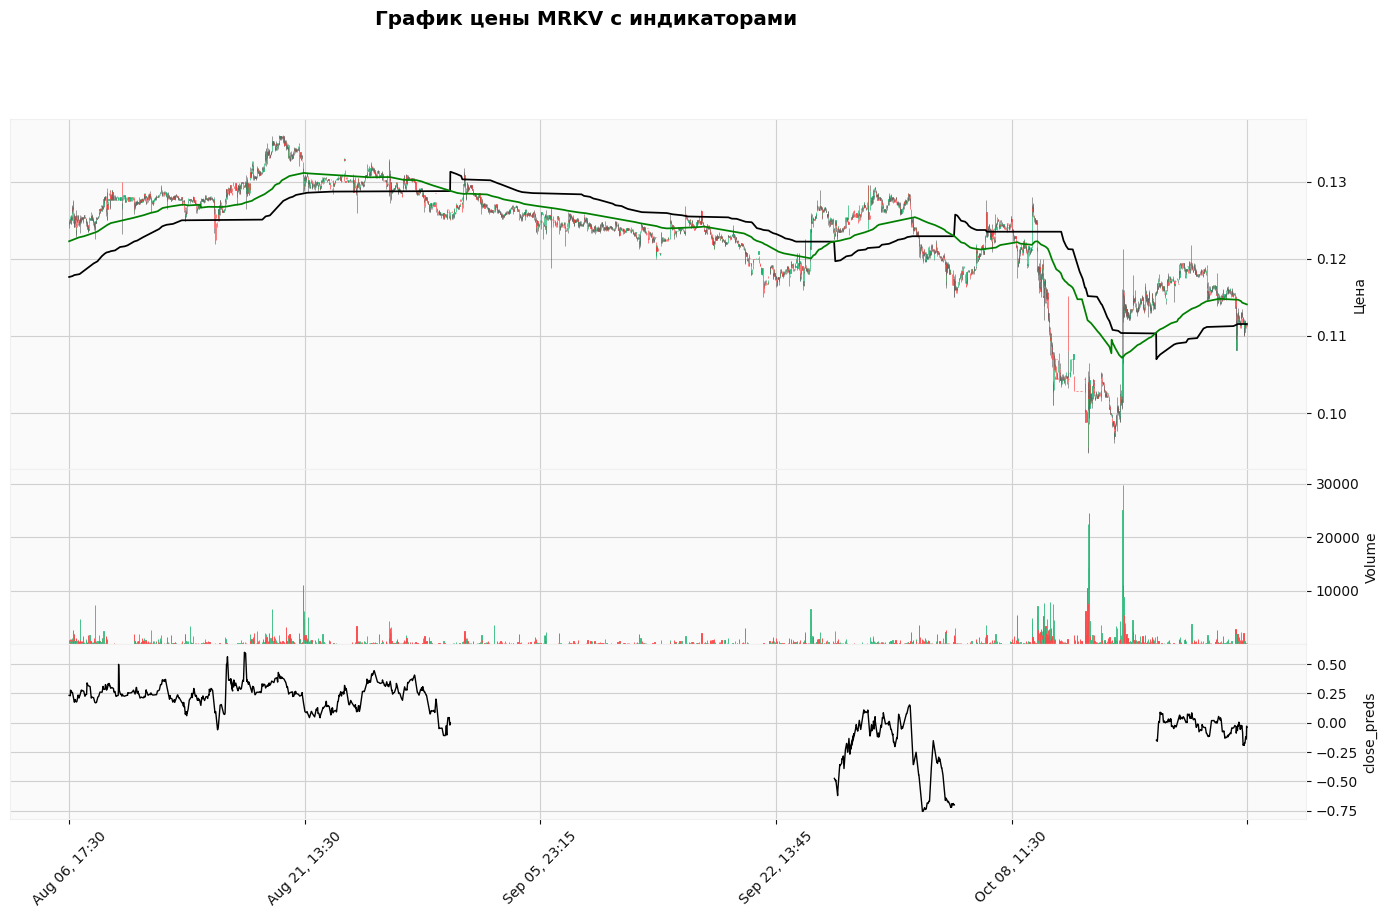

In [41]:
matplotlib.use("agg")
%matplotlib inline
plot_price_with_indicators_mplfinance1(ress['MRKV'].iloc[:], 'MRKV')

In [10]:
def plot_price_with_indicators_mplfinance1(df, ticker, save_path=None):
    """
    Отрисовывает график движения цены с индикаторами, используя mplfinance.

    Args:
        df (pd.DataFrame): DataFrame с данными о цене и индикаторах.
        ticker (str): Тикер акции для заголовка графика.
        save_path (str, optional): Путь для сохранения графика. Если None, то график покажется.
    """
    # Копируем DataFrame, чтобы не менять оригинал
    df = df.copy()

    # Преобразуем столбец time в datetime и делаем индексом
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    # Проверяем, что необходимые столбцы существуют
    required_columns = ["open", "high", "low", "close"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Отсутствует необходимый столбец: {col}")

    # Создаем список дополнительных панелей для индикаторов
    apds = []
    #if "pmax_f" in df.columns:
    #    apds.append(mpf.make_addplot(df["pmax_f"], color="red", ylabel="PMAX", panel=0))
    #if "ma_f" in df.columns:
    #    apds.append(mpf.make_addplot(df["ma_f"], color="blue", ylabel="MA", panel=0))
    if "pmax_adaptive" in df.columns:
        apds.append(mpf.make_addplot(df["pmax_adaptive"], color="red", ylabel="PMAX", panel=0))
    if "ma_adaptive" in df.columns:
        apds.append(mpf.make_addplot(df["ma_adaptive"], color="blue", ylabel="MA", panel=0))
    if "pmax" in df.columns:
        apds.append(mpf.make_addplot(df["pmax"], color="black", ylabel="PMAX", panel=0))
    if "ma" in df.columns:
        apds.append(mpf.make_addplot(df["ma"], color="green", ylabel="MA", panel=0))
    if "preds" in df.columns:
        apds.append(mpf.make_addplot(df["preds"], color="black", panel=2, ylabel='close_preds',width=1.0))

    # Отрисовка графика с mplfinance
    plot_kwargs = dict(
        type="candle",
        style="yahoo",
        title=f"График цены {ticker} с индикаторами",
        ylabel="Цена",
        addplot=apds,
        show_nontrading=False,
        figsize=(18, 10),
    )

    if "volume" in df.columns:
        plot_kwargs["volume"] = True
        plot_kwargs["panel_ratios"] = (6, 3)

    if save_path:
        plot_kwargs["savefig"] = save_path
        mpf.plot(df, **plot_kwargs)
    else:
        mpf.plot(df, **plot_kwargs)
        import matplotlib.pyplot as plt
        plt.show()